#**Patrimoni cultural del Garraf**

### **Definició del problema**

Partim d'un dataset d'elements de patrimoni cultural del Garraf obtinguts de la web de dades obertes de la Diputació de Barcelona. Té un total 1941 files i 37 columnes. El propòsit és seleccionar les columnes adients per un model de classificació multiclasse, netejar i omplir els valors faltants, fer un preprocessat, aplicar els models i fer una comparació avaluant els resultats. El target segons el que es farà la classifició és el de la variable "ambit" i es pretén classificar els elements en les categories de patrimoni immoble, moble, documental, immaterial i natural.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 24 08:24:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Obtenció de les dades**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import math
import missingno as ms
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

Obtenim el dataset fent una crida a l'API.

In [ ]:
# URL de l'API
url = 'https://do.diba.cat/api/dataset/patrimoni_cultural/format/json/pag-ini/1/pag-fi/29999/camp-rel_comarca-like/17/'

# Fer sol·licitud GET a l'API
response = requests.get(url)
data = response.json()

# Obtenir la llista d'elements del JSON
elements = data['elements']

# Crear un DataFrame de pandas amb els elements
df = pd.DataFrame(elements)

# Mostrar el DataFrame
df.head(10)

,id,titol,url,bibliografia,centuria,notes_conservacio,descripcio,codi_element,ubicacio,historia,...,inspire_atribut,data_modificació,autor_fitxa,autor_element,observacions,codi_estil,codi_tipologia,codi_tipo_sitmun,proteccio_id,rel_comarca
0,44274,Forn de calç del Fondo de l'Obaga II,https://patrimonicultural.diba.cat/element/for...,"<p>PUJOL, J.Ma. (2002): 'Patrimoni rural en Pe...",XVIII-XX,En fase d'enrunament i cobert de vegetació.,"<p>Forn de fer calç excavat a terra, només es ...",08043-4,Sector E del Fondo de l'Obaga,,...,[],2021-02-18 00:00:00,Jordi Farré,,,98|94,45,1.1,,[17]
1,44313,Can Dori,https://patrimonicultural.diba.cat/element/can...,"<p>MIRET, M. (1983). 'Cronologia i anàlisi esp...",VI-I aC.,probablement arrasat.,<p>El jaciment s'ubica a la part de darrera de...,08043-43,Plaça Maria Cristina. Urbanització Nou Canyelles.,"<p>L'any 2002, el propietari de la masia va in...",...,[Inexistent],2023-01-24 00:00:00,Jordi Farré,,Actualment les franges de terreny que es conse...,79|80|81,1754,1.4,2484,[17]
2,44329,Benedicció del terme,https://patrimonicultural.diba.cat/element/ben...,,XX,,<p>El dia de la Santa Creu es feia la benedicc...,08043-60,Nucli antic de Canyelles.,,...,[],2020-09-16 00:00:00,Josep Anton Pérez,,El contingut d'aquesta fitxa ha estat possible...,,63,4.5,,[17]
3,44339,Carrerada de Carro,https://patrimonicultural.diba.cat/element/car...,"<p>ROVIRA i MERINO, J. MIRALLES i SABADELL, F....",,Molt desvirtuada degut al fort procés d'urbani...,<p>Camí per on el bestiar té dret de passar i ...,08043-70,Urbanització Califòrnia.,,...,[],2023-01-24 00:00:00,Jordi Farré,,,,49,1.5,,[17]
4,44346,Fondo de l'Obaga,https://patrimonicultural.diba.cat/element/fon...,,,,<p>El fondo de l'Obaga divideix dues vessants ...,08043-77,Fondo de l'Obaga. Parc d'Olèrdola.,,...,[Xarxa natura 2000],2023-01-24 00:00:00,Josep Anton Pérez,,,,2153,5.1,1764,[17]
5,44355,Goigs en alabansa de Santa Maria de Magdalena,https://patrimonicultural.diba.cat/element/goi...,,XX,,"<p>Goigs dedicats a Santa Maria Magdalena, pat...",08043-86,,,...,[],2021-03-08 00:00:00,Josep Anton Pérez,Ricard Vives i Sabaté. Música de Mn. Josep Mai...,No hem estudiat publicacions originals sinó cò...,,62,4.4,,[17]
6,87780,Cementiri de Canyelles,https://patrimonicultural.diba.cat/element/cem...,,XIX-XX,,<p>El cementiri de Canyelles està situat a l'e...,08043-104,Camí del Cementiri,,...,[Inexistent],2023-01-24 00:00:00,"Marta Lloret Blackburn-Antequem, S.L.",,,98,45,1.1,2484,[17]
7,87812,Bassa de Vora Sitges,https://patrimonicultural.diba.cat/element/bas...,,,,<p>La bassa de de Vora Sitges està situada al ...,08043-119,C. de la Casa Nova,,...,[Inexistent],2023-02-01 00:00:00,"Marta Lloret Blackburn-Antequem, S.L.",,L'Ajuntament de Canyelles hi ha col·locat un p...,,2153,5.1,2484,[17]
8,87832,Barraca de Can Pasqual II,https://patrimonicultural.diba.cat/element/bar...,,XVIII-XX,,<p><span><span><span>Barraca de vinya situada ...,08043-138,Pla del Bosc,,...,[Inexistent],2023-02-01 00:00:00,"Marta Lloret Blackburn-Antequem, S.L.",,,98|94,45,1.1,2484,[17]
9,87842,Barraca del bosc del Collet II,https://patrimonicultural.diba.cat/element/bar...,,XVIII-XX,,<p><span><span><span>Barraca de vinya situada ...,08043-148,El Collet,,...,[Inexistent],2023-02-01 00:00:00,"Marta Lloret Blackburn-Antequem, S.L.",,,98|94,45,1.1,2484,[17]


In [ ]:
df.columns

Index(['id', 'titol', 'url', 'bibliografia', 'centuria', 'notes_conservacio',
       'descripcio', 'codi_element', 'ubicacio', 'historia', 'coordenades',
       'utm_x', 'utm_y', 'any', 'rel_municipis', 'municipi_nom', 'tipus_acces',
       'estat_conservacio', 'images', 'proteccio', 'estil', 'ambit',
       'tipologia', 'titularitat', 'us_actual', 'inspire_tipus',
       'inspire_subtipus', 'inspire_atribut', 'data_modificació',
       'autor_fitxa', 'autor_element', 'observacions', 'codi_estil',
       'codi_tipologia', 'codi_tipo_sitmun', 'proteccio_id', 'rel_comarca'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1941 non-null   object
 1   titol              1941 non-null   object
 2   url                1941 non-null   object
 3   bibliografia       1941 non-null   object
 4   centuria           1941 non-null   object
 5   notes_conservacio  1941 non-null   object
 6   descripcio         1941 non-null   object
 7   codi_element       1941 non-null   object
 8   ubicacio           1941 non-null   object
 9   historia           1941 non-null   object
 10  coordenades        1941 non-null   object
 11  utm_x              1941 non-null   object
 12  utm_y              1941 non-null   object
 13  any                1941 non-null   object
 14  rel_municipis      1941 non-null   object
 15  municipi_nom       1941 non-null   object
 16  tipus_acces        1941 non-null   object


In [ ]:
df.shape

(1941, 37)

### **Configuració del dataset per la classificació**

Configurem el dataset amb el què volem treballar seleccionant les variables que resultin més rellevants. Al dataset original hi ha moltes variables que no són útils per un model de Machine Learning o que són redundants (per exemple protecció i protecció_id): bibliografia, notes de conservació, enllaços web, imatges, coordenades, codis d'elements, autors de fitxes, codis de comarques, etc. Nombrem el nou dataset com a 'patrimoni'.

In [ ]:
patrimoni = df[['titol', 'centuria', 'any','municipi_nom', 'proteccio', 'estil', 'tipologia', 'ambit', 'titularitat', 'us_actual', 'estat_conservacio']].copy()

In [ ]:
patrimoni.head()


,titol,centuria,any,municipi_nom,proteccio,estil,tipologia,ambit,titularitat,us_actual,estat_conservacio
0,Forn de calç del Fondo de l'Obaga II,XVIII-XX,,Canyelles,Inexistent,Contemporani|Modern,Edifici,Patrimoni immoble,Privada,Sense ús,Dolent
1,Can Dori,VI-I aC.,,Canyelles,Inexistent,Edats dels Metalls|Antic|Ibèric,Jaciment arqueològic,Patrimoni immoble,Privada,Altres,Dolent
2,Benedicció del terme,XX,,Canyelles,Inexistent,,Costumari,Patrimoni immaterial,Pública,Sense ús,
3,Carrerada de Carro,,,Canyelles,Legal,,Obra civil,Patrimoni immoble,Pública,Social,Dolent
4,Fondo de l'Obaga,,,Canyelles,Legal,,Zona d'interès,Patrimoni natural,Privada,Social,Bo


### **Anàlisi de dades**

In [ ]:
patrimoni.describe()

,titol,centuria,any,municipi_nom,proteccio,estil,tipologia,ambit,titularitat,us_actual,estat_conservacio
count,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941,1941
unique,1910,122,199,5,4,184,19,5,3,14,4
top,Carrer Major,XX,,Sitges,Inexistent,,Edifici,Patrimoni immoble,Privada,Residencial,Bo
freq,3,403,1542,813,1012,493,963,1411,1369,585,1371


Aquí veiem que hi ha un total de 1941 registres i que el tipus d'element més freqüent és l'edifici, patrimoni immoble, de propietat privada, residencial, en bon estat, sense cap tipus de protecció i a Sitges. 

In [ ]:
patrimoni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   titol              1941 non-null   object
 1   centuria           1941 non-null   object
 2   any                1941 non-null   object
 3   municipi_nom       1941 non-null   object
 4   proteccio          1941 non-null   object
 5   estil              1941 non-null   object
 6   tipologia          1941 non-null   object
 7   ambit              1941 non-null   object
 8   titularitat        1941 non-null   object
 9   us_actual          1941 non-null   object
 10  estat_conservacio  1941 non-null   object
dtypes: object(11)
memory usage: 166.9+ KB


Totes les variables són de tipus objecte.

Fem una exploració gràfica inicial. Com que la majoria de variables són categòriques, aplicarem un countplot per visualitzar les distribucions.

In [ ]:
import seaborn as sns

def plot_countplots(data):
    # Obtenir les columnes del DataFrame excepte 'Títol' y 'Any'
    columns = [col for col in data.columns if col not in ['titol', 'any']]
    
    # Configurar l'estil de color
    sns.set_palette('Set2')
    
    # Iterar sobre las columnes i crear els gràfics countplot
    for col in columns:
        plt.figure(figsize=(15, 8))
        sns.countplot(data=data, x=col, order=data[col].value_counts().index)
        plt.title(f'Countplot de {col}')
        plt.xticks(rotation=90)  
        plt.show()

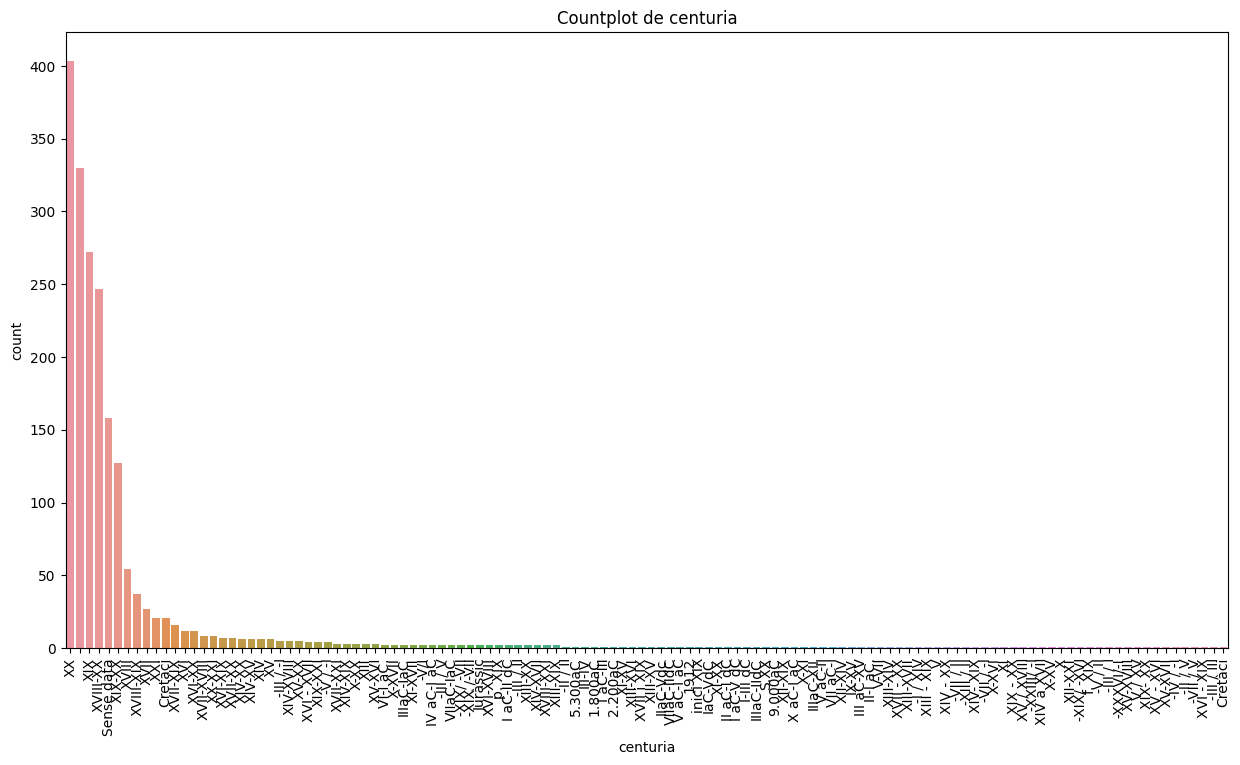

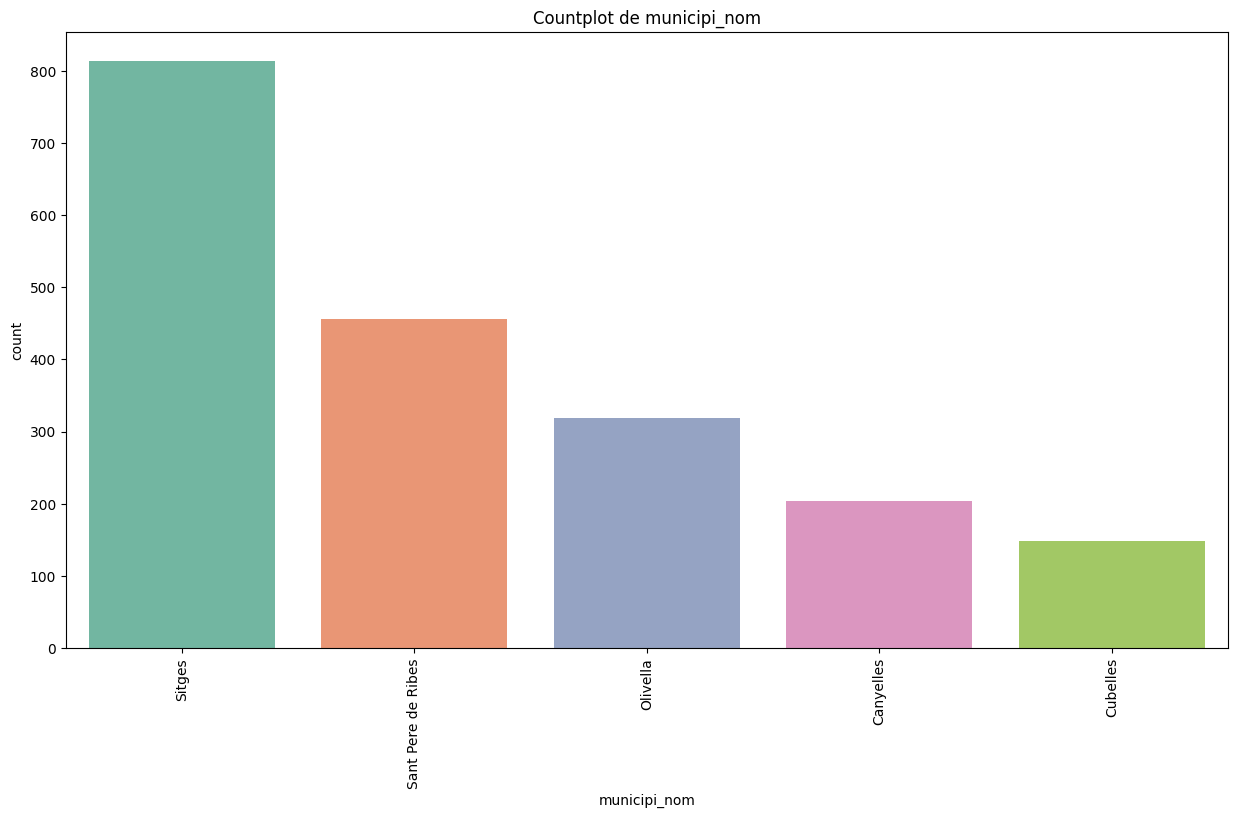

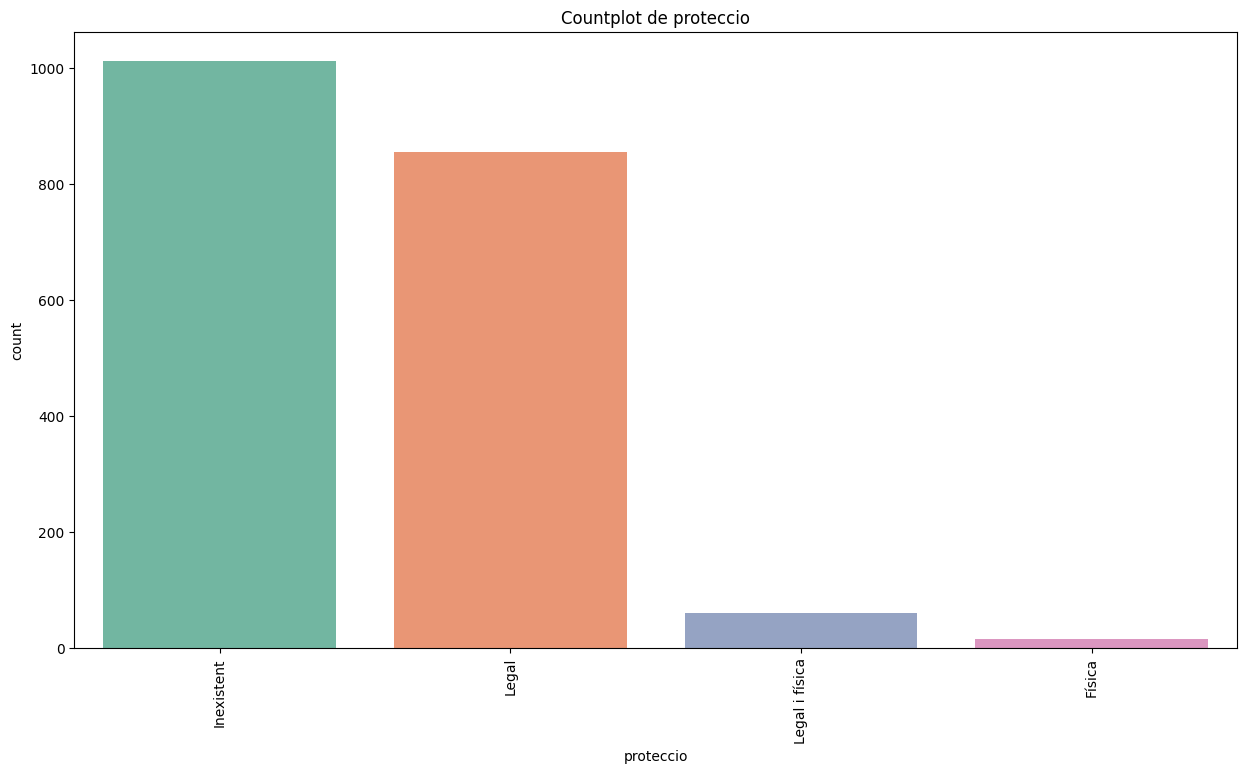

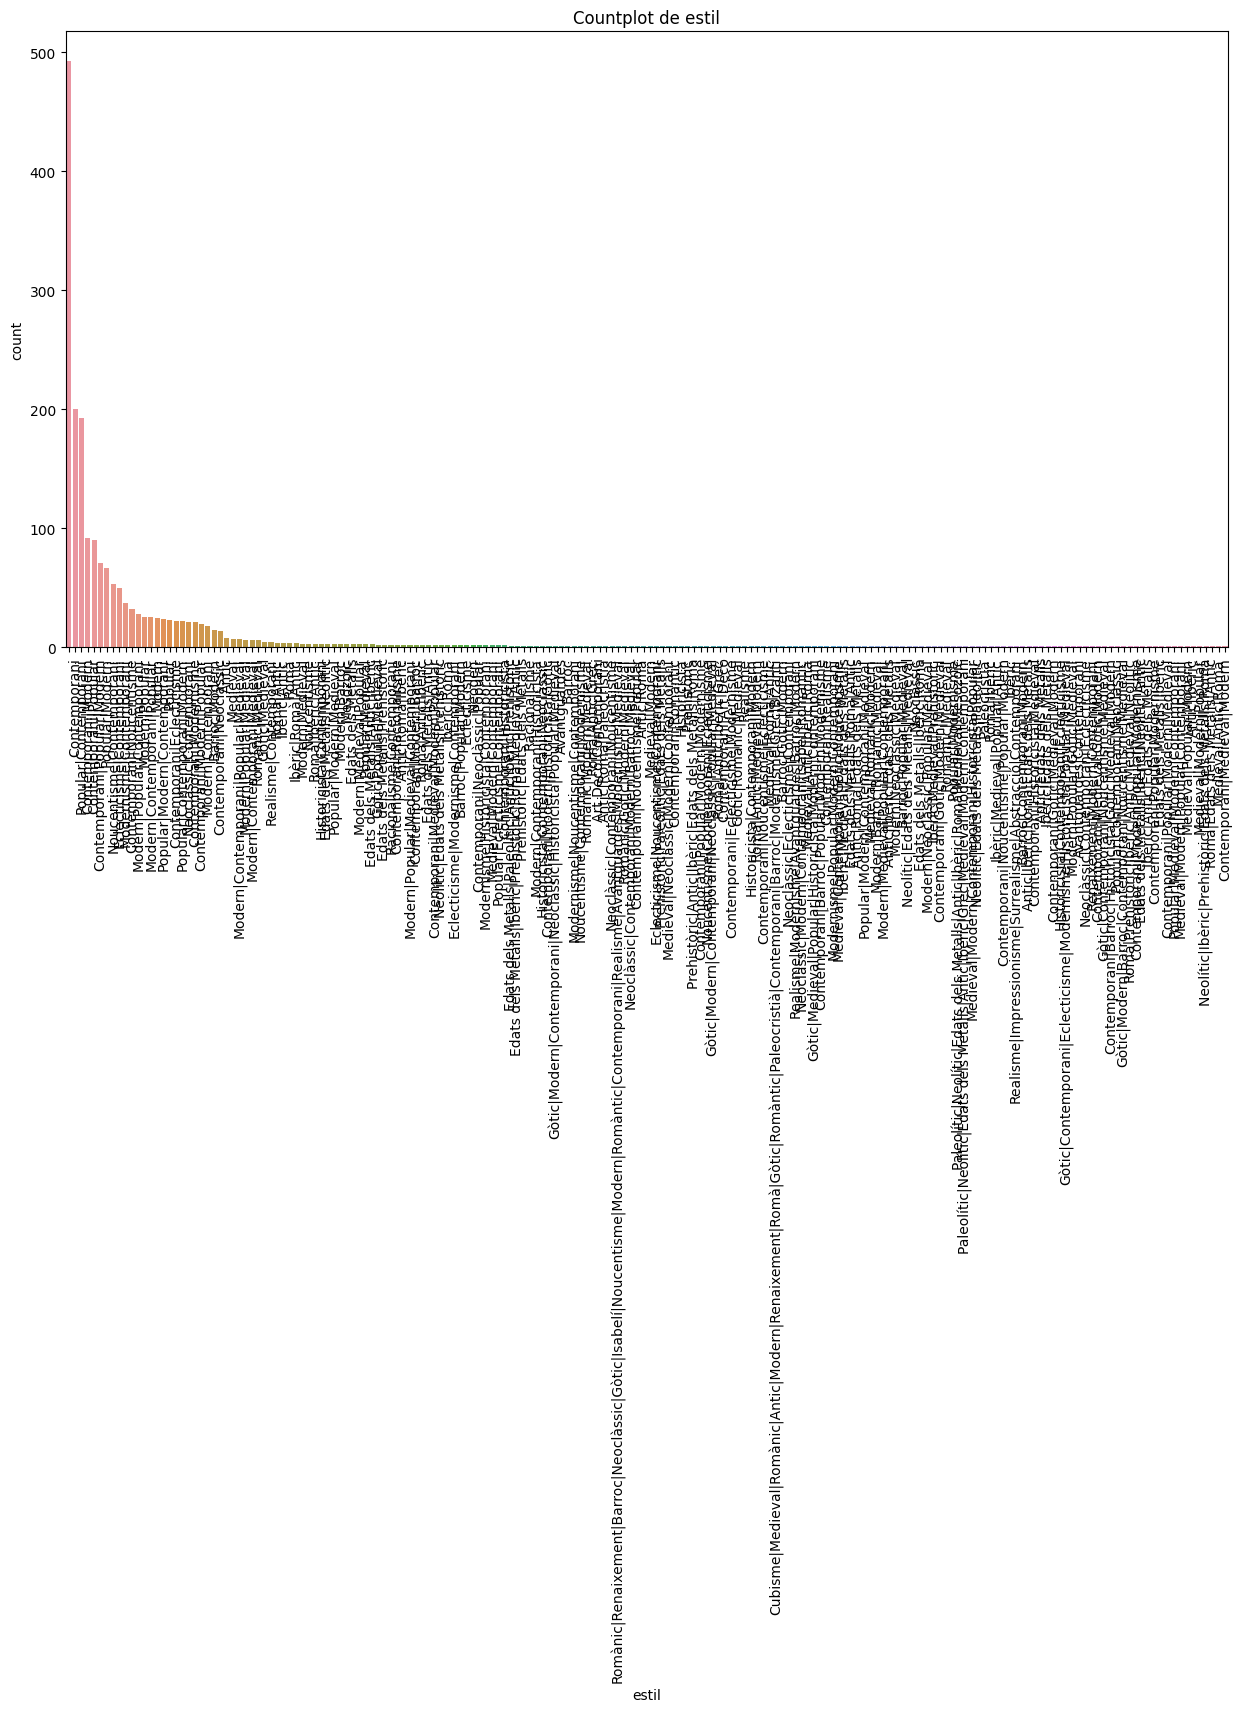

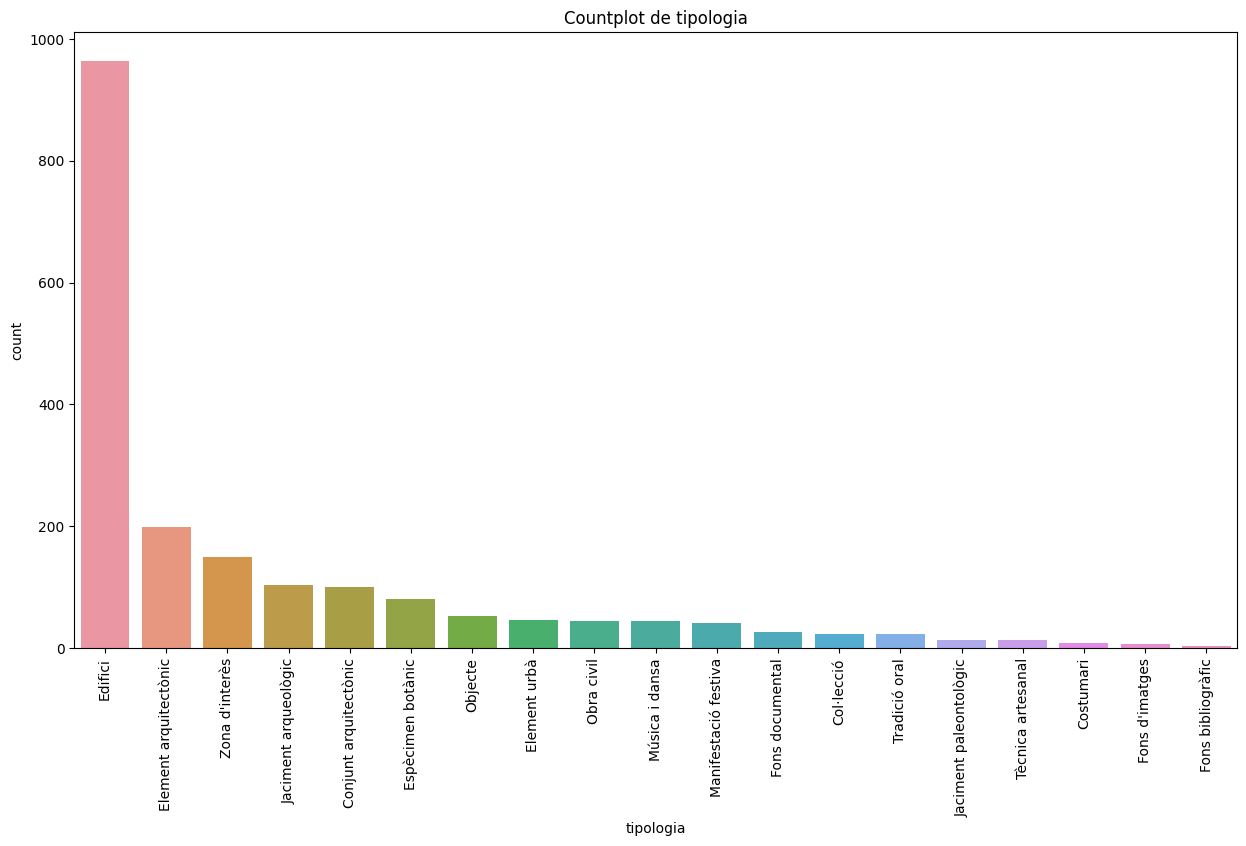

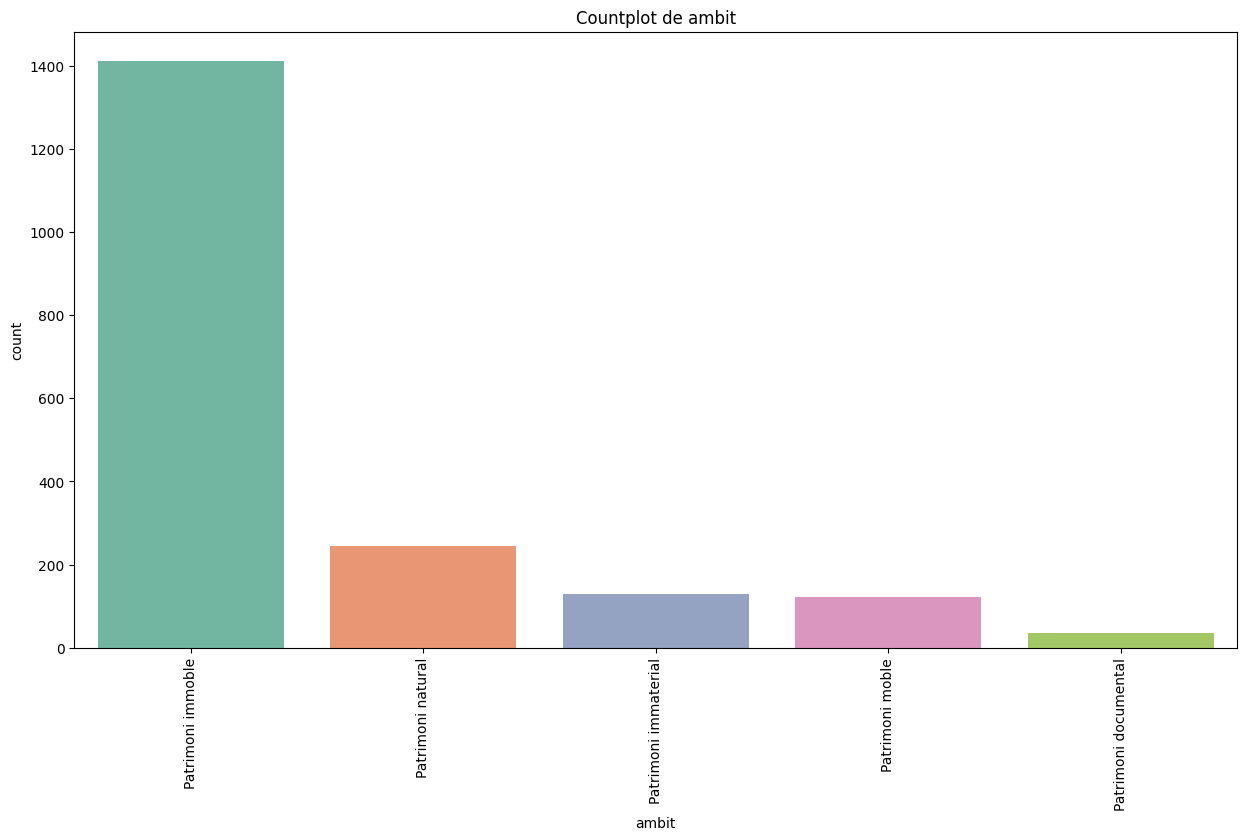

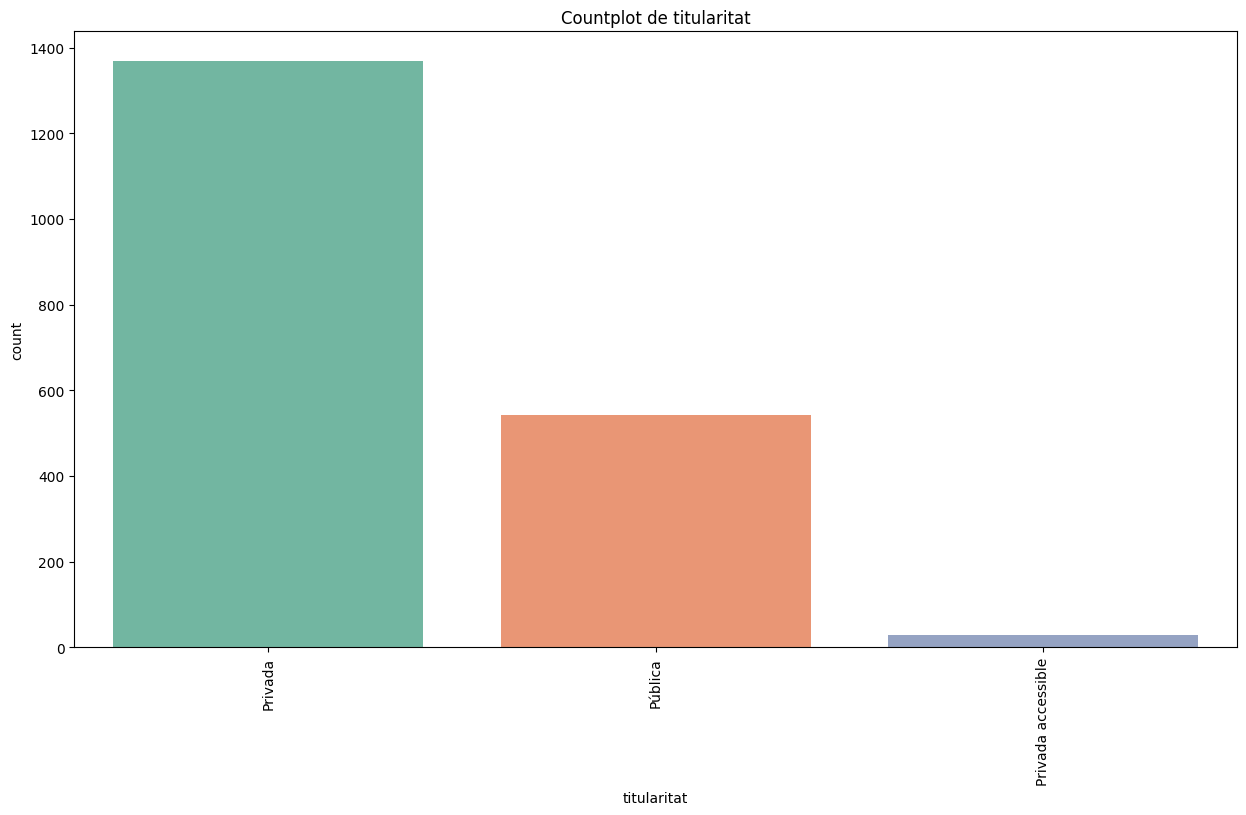

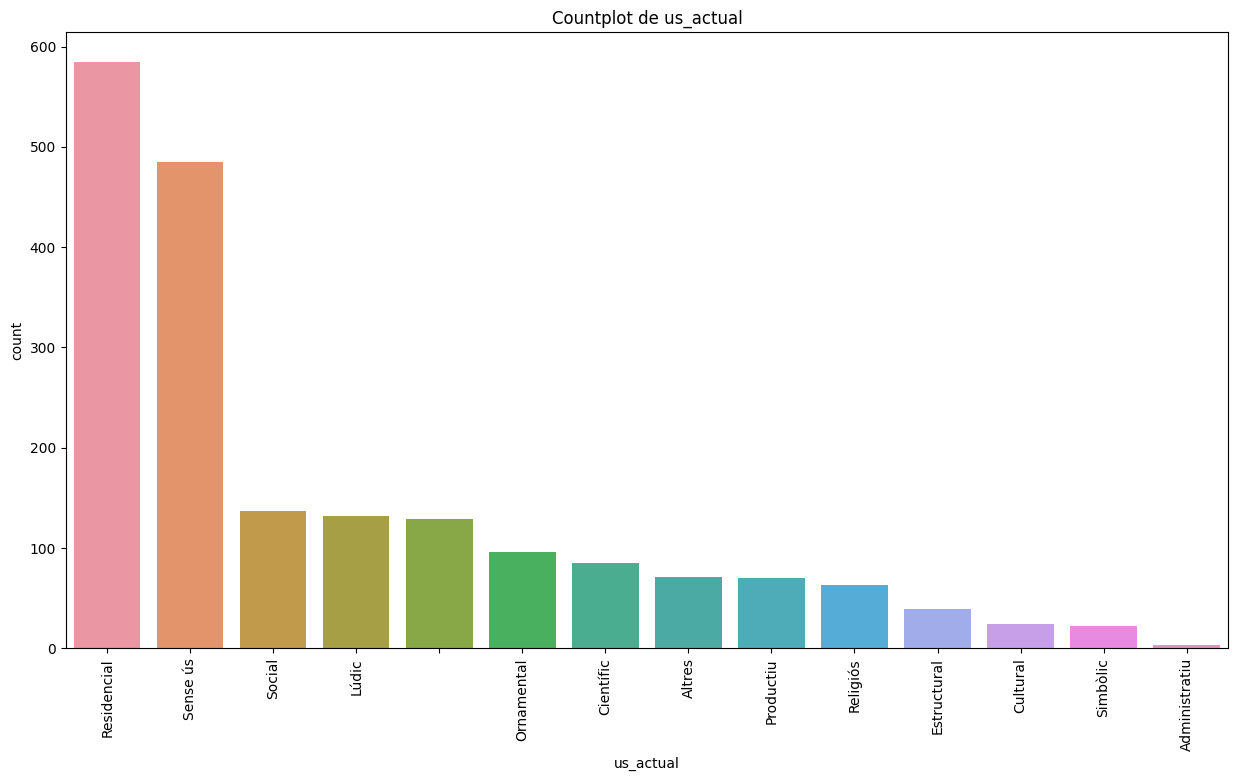

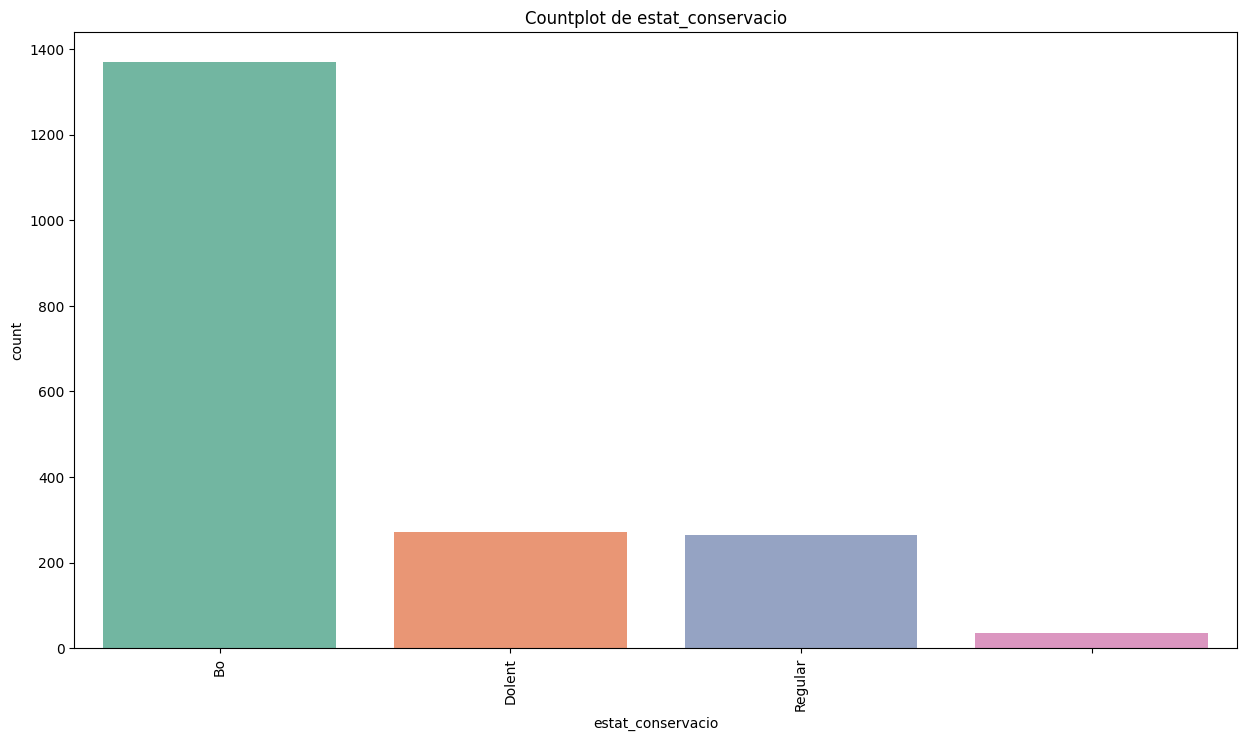

In [ ]:
plot_countplots(patrimoni)

D'entrada podem observar que la variable 'centuria' conté molts registres i això ens farà difícil aplicar un model de Machine Learning. La proposta serà unificar-ho tot per èpoques o edats agrupant els segles per categories. Una altra cosa destacable és que hi ha massa estils i d'entrada sembla difícil unificar-los. A més, la major categoria conté elements nulls, així que el més probable és que s'elimini. 



*   Centuria: la més freqüent és el segle XX, seguida del XIX, XVIII i 'Sense data'.
*   Municipi: el que aglutina més registres és Sitges, després Sant Pere de Ribes, Olivella i per últim Canyelles i Cubelles.
*   Protecció: més de la meitat del patrimoni del Garraf no té protecció, l'altre meitat, gairebé, en té de legal. Molt per sota hi ha el patrimoni que en té de legal i física i molt poc en té de física.
*   Estil: Hi ha molts estils, la majoria desconeguts, seguit per estil contemporani.
*   Tipologia: la gran majoria són edificis i elements arquitectònics, zones d'interés i elements arqueològics. 
*   Àmbit: Pel que fa a l'àmbit, el majoritari és el patrimoni immoble, seguit de patrimoni natural, patrimoni immaterial, patrimoni moble i patrimoni documental. 
*   Titularitat: la gran majoria de patrimoni és privada, bastant per sota pública i per últim i en menor mesura privada accessible.
*   Ús actual: pel que fa a usos, la major part és d'ús privat, no té ús o té un ús social o lúdic. 
*   Estat de conservació: Per últim, la majoria de patrimoni està en bon estat i força per sota i quasi en empat, té un estat dolent o regular.

Fent el recompte de valors de la variable 'any' veiem que falten la majoria de valors, així que l'eliminarem, no ens aporta prou informació. Al seu lloc utilitzarem la informació que ens aporta la columna 'centuria'.

### **Neteja i substitució de les dades faltants**

In [ ]:
patrimoni['any'].value_counts()

           1542
1919          9
c. 1850       9
1800-50       8
1915          7
           ... 
1902          1
1940          1
1893-94       1
1845          1
1979          1
Name: any, Length: 199, dtype: int64

In [ ]:
patrimoni = patrimoni.drop('any', axis=1)

In [ ]:
patrimoni['centuria'].value_counts()

XX            403
              330
XIX           272
XVIII-XX      247
Sense data    158
             ... 
-II / V         1
-VII / V        1
XVI - XIX       1
-III / III      1
Cretàci         1
Name: centuria, Length: 122, dtype: int64

In [ ]:
unique_centuria = patrimoni['centuria'].unique()
print(unique_centuria)

['XVIII-XX' 'VI-I aC.' 'XX' '' 'XIX-XX' 'XVIII' 'XXI' 'XVII' 'XIX'
 'XIV-XVIII' 'XVII-XX' 'XV' 'XIX-XXI' 'XVI' 'XVIII-XXI' 'XIV' 'XV-XX'
 'XVIII-XIX' 'II-I aC.' 'XI-XX' 'XVI-XX' 'X-XX' 'IaC-VdC' 'XX-XXI'
 'XIII-XIX' 'IIaC-Vdc' 'V-VII' 'XVII-XIX' 'XVII-XXI' 'II aC-I dC'
 'XII-XXI' 'XIV-XX' 'XIII-XX' 'XVII-XVIII' 'XV-XVII' 'X-XV' 'XVI - XVII'
 'XIII - XIX' 'XIV - XX' 'XIII-XVII' 'XIX - XX' 'XIV-XVII' 'XIII'
 'XIV a XVII' 'XVII - XX' '-II / II' '-V / -I' '-III / V' 'XIV-XIX'
 'X-XVII' 'XVI-XIX' 'XI-XVII' '-XXIII/ -I' 'XV / XVIII' 'XV-XVI' 'XI'
 'X-XVI' 'XIV- XIX' '-V/I' '-XIII / II' '-VII / II' '-III / II' 'V'
 '-III / -I' '-I / XIV' '-XIX/ -VII' '-VII / -I' 'X' 'XV - XVI'
 '-III / III' 'XVI - XIX' '-VII / V' '-II / V' '-IV / -I' '-XIX /-VII'
 'XIX- XX' '-XIX/ -XVI' 'XVI-XVIII' 'V / XV' 'XV-XVIII' '-XXXVI/-I'
 '-III / I' '-V / II' 'f. XIX' 'Sense data' 'XIII-XIV' 'Cretaci' 'XIV-XV'
 'inici XIX' '1912' 'V aC-I aC' 'VIIaC-IIdC' 'I aC-II dC' 'XIII-XV'
 'XIII-XVI' 'XI-XV' 'VIIaC-IaC' '2.200aC

Veiem que hi ha massa categories. Ara mirem visualitzem els elements que no tenen data.

In [ ]:
df_filtered = patrimoni[patrimoni["centuria"] == "Sense data"]

In [ ]:
df_filtered.head(50)

,titol,centuria,municipi_nom,proteccio,estil,tipologia,ambit,titularitat,us_actual,estat_conservacio
1135,Avenc del Puig Sabataire,Sense data,Sitges,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Lúdic,Bo
1136,Avenc de les Branques,Sense data,Sitges,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Lúdic,Bo
1137,Avenc del Pito,Sense data,Sitges,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Lúdic,Bo
1148,Gorgònies de la zona de Vallcarca,Sense data,Sitges,Legal,,Zona d'interès,Patrimoni natural,Pública,Social,Dolent
1175,Penó de Sant Bartomeu,Sense data,Sitges,Inexistent,Contemporani,Objecte,Patrimoni moble,Pública,Científic,Bo
1188,"Plaça de l'Ajuntament, 4",Sense data,Sitges,Legal,Contemporani|Popular,Edifici,Patrimoni immoble,Privada,Residencial,Bo
1197,Avenc de l'Esbit,Sense data,Sitges,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Lúdic,Bo
1213,Cova de la Llastra,Sense data,Sitges,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Lúdic,Bo
1216,"Plaça de l'Ajuntament, 5-6",Sense data,Sitges,Legal,Contemporani|Popular,Edifici,Patrimoni immoble,Privada,Residencial,Bo
1217,"Plaça de l'Ajuntament, 7-8",Sense data,Sitges,Legal,Contemporani,Conjunt arquitectònic,Patrimoni immoble,Privada,Residencial,Bo


Si observem la columna de 'centuria', els elements patrimonials que no tenen data és sovint perquè són elements naturals com coves i festes populars. És possible que no se'n tingui una data exacta de creació. Ho canviem a "Sense data".


In [ ]:

patrimoni.loc[patrimoni["centuria"].isna(), "centuria"] = "Sense data"


In [ ]:
patrimoni['centuria'].unique()


array(['XVIII-XX', 'VI-I aC.', 'XX', '', 'XIX-XX', 'XVIII', 'XXI', 'XVII',
       'XIX', 'XIV-XVIII', 'XVII-XX', 'XV', 'XIX-XXI', 'XVI', 'XVIII-XXI',
       'XIV', 'XV-XX', 'XVIII-XIX', 'II-I aC.', 'XI-XX', 'XVI-XX', 'X-XX',
       'IaC-VdC', 'XX-XXI', 'XIII-XIX', 'IIaC-Vdc', 'V-VII', 'XVII-XIX',
       'XVII-XXI', 'II aC-I dC', 'XII-XXI', 'XIV-XX', 'XIII-XX',
       'XVII-XVIII', 'XV-XVII', 'X-XV', 'XVI - XVII', 'XIII - XIX',
       'XIV - XX', 'XIII-XVII', 'XIX - XX', 'XIV-XVII', 'XIII',
       'XIV a XVII', 'XVII - XX', '-II / II', '-V / -I', '-III / V',
       'XIV-XIX', 'X-XVII', 'XVI-XIX', 'XI-XVII', '-XXIII/ -I',
       'XV / XVIII', 'XV-XVI', 'XI', 'X-XVI', 'XIV- XIX', '-V/I',
       '-XIII / II', '-VII / II', '-III / II', 'V', '-III / -I',
       '-I / XIV', '-XIX/ -VII', '-VII / -I', 'X', 'XV - XVI',
       '-III / III', 'XVI - XIX', '-VII / V', '-II / V', '-IV / -I',
       '-XIX /-VII', 'XIX- XX', '-XIX/ -XVI', 'XVI-XVIII', 'V / XV',
       'XV-XVIII', '-XXXVI/-I', '-III / 

En aquest punt sintetitzarem tots els segles i èpoques que tenim en diverses categories (podrien ser més precises però en el nostre cas és millor que no siguin gaires) i ho apliquem en forma de diccionari als diferents segles que trobem.

In [ ]:
mapping = {
    'IaC': 'Antiga',
    'IIaC': 'Antiga',
    'IIIaC': 'Antiga',
    'IVaC': 'Antiga',
    'VaC': 'Antiga',
    'VIaC': 'Antiga',
    'VIIaC': 'Antiga',
    'VIIIaC': 'Antiga',
    'IXaC': 'Antiga',
    'XaC': 'Antiga',
    'XI': 'Antiga',
    'XII': 'Antiga',
    'XIII': 'Antiga',
    'IV aC-I aC': 'Antiga',
    'V aC-II': 'Antiga',
    'VIIaC-I': 'Antiga',
    'I-III dC': 'Antiga',
    'III-IV': 'Antiga',
    'IV-V': 'Antiga',
    'V-VII': 'Antiga',
    'VII-VIII': 'Antiga',
    'VIII-IX': 'Antiga',
    'IX-X': 'Antiga',
    'X-XI': 'Antiga',
    'XI-XII': 'Antiga',
    'XII-XIII': 'Antiga',
    'XIV': 'Mitjana',
    'XV': 'Mitjana',
    'XIV-XV': 'Mitjana',
    'XVI': 'Moderna',
    'XVII': 'Moderna',
    'XVIII': 'Moderna',
    'XIX': 'Contemporània',
    'XX': 'Contemporània',
    'XXI': 'Contemporània',
    'Sense data': 'Sense data',
    'XV-XX': 'Moderna',
    'XIX-XXI': 'Contemporània',
    'XIX-XX': 'Contemporània',
    'XVIII-XX': 'Moderna',
    'XI-XX': 'Mitjana',
    'XIV-XVIII': 'Mitjana',
    'XVIII-XXI': 'Moderna',
    'XVIII-XIX': 'Moderna',
    'XVII-XX': 'Moderna',
    'II-I aC.': 'Antiga',
    'VI-I aC.': 'Antiga',
    'X-XX': 'Mitjana',
    'II aC-I dC': 'Antiga',
    'XX-XXI': 'Contemporània',
    'XVII-XVIII': 'Moderna',
    'XVI-XX': 'Moderna',
    'XII-XXI': 'Mitjana',
    'XV-XVII': 'Moderna',
    'XVII-XXI': 'Moderna',
    'XIII-XIX': 'Mitjana',
    'XIV-XX': 'Mitjana',
    'XVII-XIX': 'Moderna',
    'IaC-VdC': 'Antiga',
    'XIII-XX': 'Mitjana',
    'IIaC-Vdc': 'Antiga',
    'VIIaC-IIdC': 'Antiga',
    'VIIaC-IaC': 'Antiga',
    'XIII-XVII': 'Mitjana',
    'XIV-XVII': 'Mitjana',
    'XIII - XIX': 'Mitjana',
    'XIV a XVII': 'Mitjana',
    'XIV - XX': 'Mitjana',
    'XVI - XVII': 'Moderna',
    'X-XV': 'Mitjana',
    'XIX - XX': 'Contemporània',
    'XVII - XX': 'Moderna',
    '-V/I': 'Antiga',
    '-II / II': 'Antiga',
    '-V / II': 'Antiga',
    'XVI-XIX': 'Moderna',
    'XIV-XIX': 'Moderna',
    '-III / -I': 'Antiga',
    '-XXIII/ -I': 'Antiga',
    '-XIX /-VII': 'Antiga',
    '-I / XIV': 'Antiga',
    'XVI-XVIII': 'Moderna',
    '-XIII / II': 'Antiga',
    'XV / XVIII': 'Moderna',
    '-VII / -I': 'Antiga',
    '-III / III': 'Antiga',
    '-V / -I': 'Antiga',
    'X': 'Mitjana',
    '-III / V': 'Antiga',
    'XIV- XIX': 'Moderna',
    '-VII / II': 'Antiga',
    '-IV / -I': 'Antiga',
    'XV-XVI': 'Moderna',
    'XV - XVI': 'Moderna',
    'XVI - XIX': 'Moderna',
    'XI-XVII': 'Mitjana',
    '-XIX/ -XVI': 'Antiga',
    'V / XV': 'Mitjana',
    'X-XVI': 'Mitjana',
    'V': 'Mitjana',
    'X-XVII': 'Mitjana',
    'XV-XVIII': 'Moderna',
    '-XIX/ -VII': 'Antiga',
    '-II / V': 'Antiga',
    '-VII / V': 'Antiga',
    '-XXXVI/-I': 'Antiga',
    '-III / I': 'Antiga',
    'XIX- XX': 'Contemporània',
    'inici XIX': 'Contemporània',
    'XIII-XIV': 'Mitjana',
    '1912': 'Contemporània',
    'f. XIX': 'Contemporània',
    'Cretaci': 'Antiga',
    'XVII i XIX': 'Moderna',
    'p. XIX': 'Contemporània',
    '-III / II': 'Antiga',
    'XII-XIX': 'Mitjana',
    'IIIaC-IaC': 'Antiga',
    'IX-XV': 'Mitjana',
    'V aC-I aC': 'Antiga',
    '9.000aC': 'Prehistòria',
    '2.200aC': 'Prehistòria',
    'XIII-XV': 'Mitjana',
    'X aC-I aC': 'Antiga',
    'S.XX': 'Contemporània',
    'I aC-V dC': 'Antiga',
    'IIIaC-XII': 'Antiga',
    'XII-XIV': 'Mitjana',
    'VII aC-I': 'Antiga',
    'XI-XV': 'Mitjana',
    '5.300aC': 'Prehistòria',
    'IIIaC-IIdC': 'Antiga',
    'Cretaci': 'Prehistòria',
    'I aC-II dC': 'Antiga',
    'Juràssic': 'Prehistòria',
    'XIII-XVI': 'Mitjana',
    'I aC-III': 'Antiga',
    '1.800aC': 'Antiga',
    'III aC-XV': 'Antiga',
    'Cretaci' : 'Prehistòria',
}


patrimoni['centuria'] = patrimoni['centuria'].replace(mapping)

Mirem quins registres únics tenim:

In [ ]:
patrimoni['centuria'].unique()


array(['Moderna', 'Antiga', 'Contemporània', '', 'Mitjana', 'Sense data',
       'Prehistòria', 'Cretàci'], dtype=object)

In [ ]:
patrimoni['centuria'] = patrimoni['centuria'].replace('Cretàci', 'Cretaci')

In [ ]:
patrimoni['centuria'].isna().sum()

0

Veiem que els elements amb Centuria NaN tenen una tipologia semblant que els elements que tenen assignat "Sense data", els assignarem la mateixa categoria.

In [ ]:
patrimoni['centuria'].unique()


array(['Moderna', 'Antiga', 'Contemporània', '', 'Mitjana', 'Sense data',
       'Prehistòria', 'Cretaci'], dtype=object)

Localitzem la categoria "Cretaci" i la canviem a "Prehistòria".

In [ ]:
patrimoni.loc[patrimoni['centuria'] == 'Cretaci']

,titol,centuria,municipi_nom,proteccio,estil,tipologia,ambit,titularitat,us_actual,estat_conservacio
1889,Avenc de Vallbona,Cretaci,Sitges,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Lúdic,Bo


In [ ]:
patrimoni.loc[patrimoni['centuria'] == 'Cretaci', 'centuria'] = 'Prehistòria'

Busquem els elements que quedin en blanc de "Centuria" i els canviem per "Sense data".

In [ ]:
patrimoni.loc[patrimoni['centuria'] == '']

,titol,centuria,municipi_nom,proteccio,estil,tipologia,ambit,titularitat,us_actual,estat_conservacio
3,Carrerada de Carro,,Canyelles,Legal,,Obra civil,Patrimoni immoble,Pública,Social,Dolent
4,Fondo de l'Obaga,,Canyelles,Legal,,Zona d'interès,Patrimoni natural,Privada,Social,Bo
7,Bassa de Vora Sitges,,Canyelles,Inexistent,,Zona d'interès,Patrimoni natural,Pública,Altres,Bo
16,Olivera de Cal Simó,,Canyelles,Inexistent,,Espècimen botànic,Patrimoni natural,Privada,Ornamental,Bo
19,Nucli antic de Canyelles,,Canyelles,Inexistent,Modern|Contemporani|Medieval,Conjunt arquitectònic,Patrimoni immoble,Privada,Residencial,Bo
...,...,...,...,...,...,...,...,...,...,...
1110,Col·lecció arqueològica de la Biblioteca- Muse...,,Sant Pere de Ribes,Física,Romà|Prehistòric|Ibèric|Antic|Medieval|Neolític,Col·lecció,Patrimoni moble,Pública,Sense ús,Bo
1116,Les noces desfetes o la Comtessa pelegrina,,Sant Pere de Ribes,Inexistent,,Música i dansa,Patrimoni immaterial,Pública,Sense ús,Bo
1123,Oliveres del torrent de Mas Alba,,Sant Pere de Ribes,Inexistent,,Espècimen botànic,Patrimoni natural,Privada,Productiu,Regular
1125,Carrerada de Jafre,,Sant Pere de Ribes,Inexistent,Contemporani,Obra civil,Patrimoni immoble,Privada,Estructural,Dolent


In [ ]:
patrimoni.loc[patrimoni['centuria'] == '', 'centuria'] = 'Sense data'

Visualitzem com han quedat les noves categories. Veiem que l'ordre és: edat contemporània, seguida per "Sense data" i edat moderna. Bastant per sota trobem edat antiga, mitjana i prehistòria, que aglutinen menys elements patrimonials.

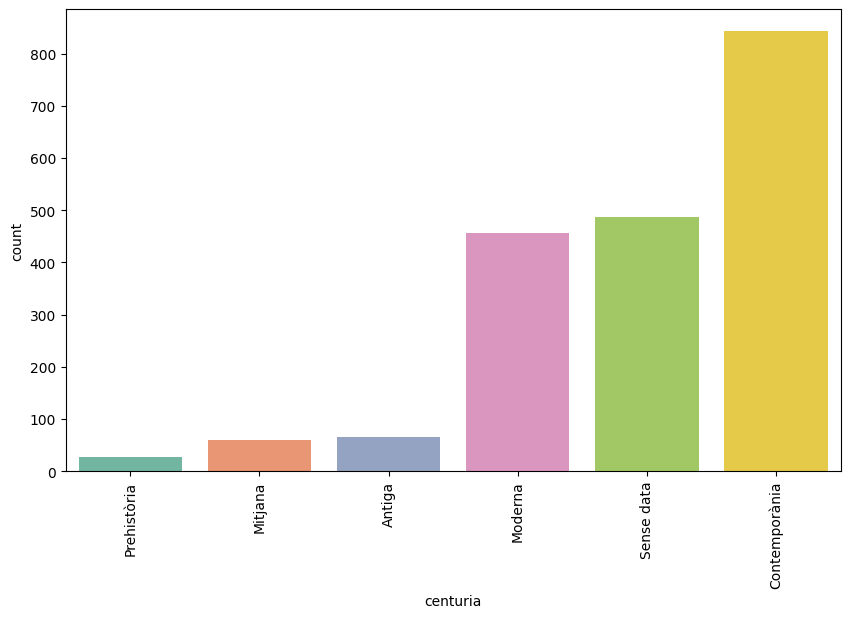

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x= patrimoni['centuria'], palette='Set2', order=patrimoni['centuria'].value_counts().sort_values().index)
plt.xticks(rotation=90)
plt.show()

Investiguem ara si queden registres null, NaN:

In [ ]:
patrimoni.isnull().sum()

titol                0
centuria             0
municipi_nom         0
proteccio            0
estil                0
tipologia            0
ambit                0
titularitat          0
us_actual            0
estat_conservacio    0
dtype: int64

In [ ]:
patrimoni.isna().sum()

titol                0
centuria             0
municipi_nom         0
proteccio            0
estil                0
tipologia            0
ambit                0
titularitat          0
us_actual            0
estat_conservacio    0
dtype: int64

Comprovem si hi ha duplicats i els eliminem.

In [ ]:
patrimoni.duplicated().sum()

4

In [ ]:
patrimoni = patrimoni.drop_duplicates()

Explorem quins són els estils faltants a simple vista.

In [ ]:
patrimoni['estil'].value_counts()

                                                       493
Contemporani                                           200
Popular|Contemporani                                   192
Contemporani|Popular                                    90
Contemporani|Modern                                     89
                                                      ... 
Medieval|Modern|Popular                                  1
Neolític|Ibèric|Prehistòric|Edats dels Metalls|Romà      1
Romà|Edats dels Metalls|Antic                            1
Medieval|Antic|Romà                                      1
Contemporani|Medieval|Modern                             1
Name: estil, Length: 184, dtype: int64

Veiem que hi ha molts estils i que la categoria més repetida és una que no està definida, per tant ens surt a compte eliminar aquesta variable.



In [ ]:
patrimoni = patrimoni.drop('estil', axis=1)

In [ ]:
patrimoni['estat_conservacio'].value_counts()

Bo         1369
Dolent      269
Regular     264
             35
Name: estat_conservacio, dtype: int64

Veiem que a estat de conservació hi ha elements que són espais en blanc però que no es reconeixen com a NaN. Ho cambiem i mirem de adjucar-los una categoria.

In [ ]:
patrimoni['estat_conservacio'] = patrimoni['estat_conservacio'].replace(['', ' ', np.nan], np.nan)

In [ ]:
patrimoni['estat_conservacio'].isna().sum()

35

In [ ]:
patrimoni[patrimoni['estat_conservacio'].isna()]

,titol,centuria,municipi_nom,proteccio,tipologia,ambit,titularitat,us_actual,estat_conservacio
2,Benedicció del terme,Contemporània,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,NaN
5,Goigs en alabansa de Santa Maria de Magdalena,Contemporània,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Residencial,NaN
21,Festa del Sagrat Cor,Contemporània,Canyelles,Inexistent,Manifestació festiva,Patrimoni immaterial,Pública,Sense ús,NaN
23,Goigs en alabansa del Sant Nicolau de Tolenti,Moderna,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Religiós,NaN
45,Goigs a llaor de la Gloriosa i Santa Magdalena...,Contemporània,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Religiós,NaN
63,Caramelles,Contemporània,Canyelles,Inexistent,Manifestació festiva,Patrimoni immaterial,Pública,Científic,NaN
64,Festa de Sant Nicolau/Festa Major Petita,Moderna,Canyelles,Inexistent,Manifestació festiva,Patrimoni immaterial,Pública,Científic,NaN
85,El trasllat dels difunts,Sense data,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,NaN
95,Incendi en un retaule de l'església,Contemporània,Canyelles,Inexistent,Tradició oral,Patrimoni immaterial,Pública,Simbòlic,NaN
119,El vi de les ànimes,Contemporània,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,NaN


Pel que fa a conservació, com que són només 35 elements i no ho podem saber, aplicarem l'estat "regular" als edificis, ja que són barraques i són espais que estan a l'exterior amb un estat de protecció "inexistent". És probable que no estiguin en perfecte estat, a la resta li apliquem "bo", que és la categoria més comú. 

In [ ]:
patrimoni.loc[(patrimoni['estat_conservacio'].isna()) & (patrimoni['tipologia'] == 'Edifici'), 'estat_conservacio'] = 'Regular'

In [ ]:
patrimoni[patrimoni['estat_conservacio'].isna()]

,titol,centuria,municipi_nom,proteccio,tipologia,ambit,titularitat,us_actual,estat_conservacio
2,Benedicció del terme,Contemporània,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,NaN
5,Goigs en alabansa de Santa Maria de Magdalena,Contemporània,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Residencial,NaN
21,Festa del Sagrat Cor,Contemporània,Canyelles,Inexistent,Manifestació festiva,Patrimoni immaterial,Pública,Sense ús,NaN
23,Goigs en alabansa del Sant Nicolau de Tolenti,Moderna,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Religiós,NaN
45,Goigs a llaor de la Gloriosa i Santa Magdalena...,Contemporània,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Religiós,NaN
63,Caramelles,Contemporània,Canyelles,Inexistent,Manifestació festiva,Patrimoni immaterial,Pública,Científic,NaN
64,Festa de Sant Nicolau/Festa Major Petita,Moderna,Canyelles,Inexistent,Manifestació festiva,Patrimoni immaterial,Pública,Científic,NaN
85,El trasllat dels difunts,Sense data,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,NaN
95,Incendi en un retaule de l'església,Contemporània,Canyelles,Inexistent,Tradició oral,Patrimoni immaterial,Pública,Simbòlic,NaN
119,El vi de les ànimes,Contemporània,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,NaN


In [ ]:
patrimoni.loc[patrimoni['estat_conservacio'].isna(), 'estat_conservacio'] = 'Bo'

Veiem que apareixen diverses barraques sense "Ús actual" i veient que de tipologia són quelcom semblant a un jaciment arqueològic i que aquests tenen la tipologia d'ús actual de "altres", ho aplicarem també. Convertim els espais en blanc a valors NaN i després els adjudiquem la categoria.

In [ ]:
patrimoni['us_actual'] = patrimoni['us_actual'].replace(['', ' ', np.nan], np.nan)

In [ ]:
patrimoni['us_actual'].isna().sum()

129

In [ ]:
pd.set_option('display.max_rows', None)

df_filtered = patrimoni[patrimoni['us_actual'].isna()]

print(df_filtered)

                         titol    centuria municipi_nom   proteccio  \
201  Albelló de Mas Rossell II     Moderna    Canyelles  Inexistent   
403                  Barraca 3  Sense data     Olivella  Inexistent   
404                Barraca 152  Sense data     Olivella  Inexistent   
405                Barraca 216  Sense data     Olivella  Inexistent   
406                 Barraca 30  Sense data     Olivella  Inexistent   
407               Barraca 8663  Sense data     Olivella  Inexistent   
408               Barraca 8306  Sense data     Olivella  Inexistent   
409               Barraca 8307  Sense data     Olivella  Inexistent   
410               Barraca 8758  Sense data     Olivella  Inexistent   
411               Barraca 8665  Sense data     Olivella  Inexistent   
423                 Barraca 24  Sense data     Olivella  Inexistent   
424                Barraca 219  Sense data     Olivella  Inexistent   
425               Barraca 2141  Sense data     Olivella  Inexistent   
426   

Veiem que quasi tots els valors faltants pertanyen a les barraques d'Olivella, així que investigarem quin ús tenen ara i ho canviarem. 

Com podem veure aquí, https://www.olivella.cat/el-municipi/turisme/patrimoni-historic-i-cultural/ :

Dins del terme municipal d’Olivella hi ha unes 125 barraques i 25 forns de calç. La majoria de construccions, integrades a l’entorn, tenen el seu origen al període que va de finals del segle XVII a finals del segle XIX. Aquesta tècnica va ser utilitzada per a l’activitat agrària i l’abastament d’aigua. Trobem aquesta informació, i veiem que són uns element patrimonials que van tenir ús fins al segle XX, llavors pordríem dir que no tenen ús actualment. 

Pel que fa a Albelló de Mas Rossell II, veiem que és una construcció per fer drenar l'aigua que es va fer servir fins el segle XX, llavors tampoc té ús. 

Aprofitem també per canviar l'època de les Barraques a "Moderna". 

In [ ]:
patrimoni['us_actual'].fillna('Sense ús', inplace=True)

Renombrem les columnes per tenir el dataset encaminat cap al seu estat definitiu.

In [ ]:
patrimoni = patrimoni.rename(columns={
    'titol': 'Títol',
    'centuria': 'Edat',
    'municipi_nom': 'Municipi',
    'proteccio': 'Protecció',
    'tipologia': 'Tipologia',
    'ambit': 'Àmbit',
    'titularitat': 'Titularitat',
    'us_actual': 'Ús actual',
    'estat_conservacio': 'Estat conservació'
})

In [ ]:
patrimoni.head(10)

,Títol,Edat,Municipi,Protecció,Tipologia,Àmbit,Titularitat,Ús actual,Estat conservació
0,Forn de calç del Fondo de l'Obaga II,Moderna,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,Dolent
1,Can Dori,Antiga,Canyelles,Inexistent,Jaciment arqueològic,Patrimoni immoble,Privada,Altres,Dolent
2,Benedicció del terme,Contemporània,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,Bo
3,Carrerada de Carro,Sense data,Canyelles,Legal,Obra civil,Patrimoni immoble,Pública,Social,Dolent
4,Fondo de l'Obaga,Sense data,Canyelles,Legal,Zona d'interès,Patrimoni natural,Privada,Social,Bo
5,Goigs en alabansa de Santa Maria de Magdalena,Contemporània,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Residencial,Bo
6,Cementiri de Canyelles,Contemporània,Canyelles,Inexistent,Edifici,Patrimoni immoble,Pública,Altres,Bo
7,Bassa de Vora Sitges,Sense data,Canyelles,Inexistent,Zona d'interès,Patrimoni natural,Pública,Altres,Bo
8,Barraca de Can Pasqual II,Moderna,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,Bo
9,Barraca del bosc del Collet II,Moderna,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,Bo


### **Anàlisi exploratori defintiu**

Tornem a fer un EDA per visualitzar la distrbució de les variables ja netes i llestres per transformar de cara al Machine Learning.

In [ ]:
import seaborn as sns

def plot_countplots(data):
 
    columns = [col for col in data.columns if col not in ['Títol']]
    
    
    sns.set_palette('Set2')
    

    for col in columns:
        plt.figure(figsize=(10, 5))  
        sns.countplot(data=data, x=col, order=data[col].value_counts().index)
        plt.title(f'Countplot de {col}')
        plt.xticks(rotation=90)  
        plt.show()

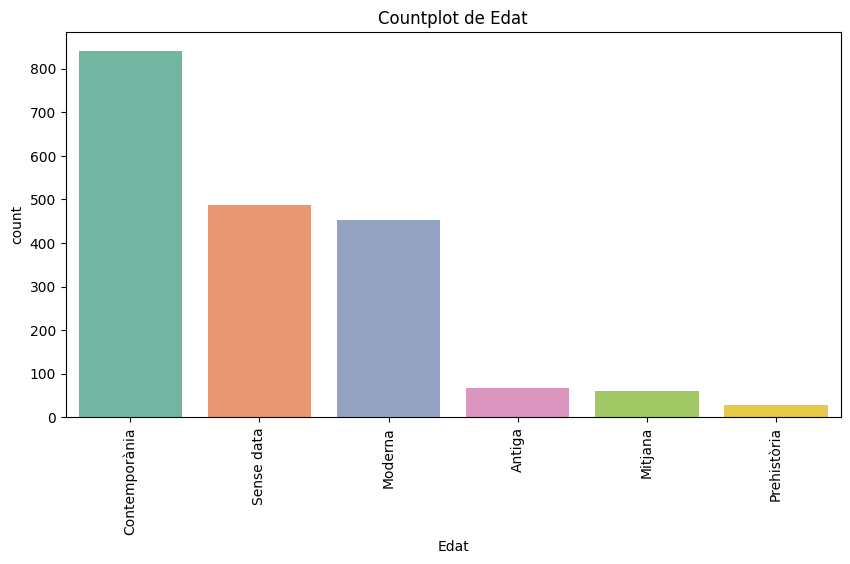

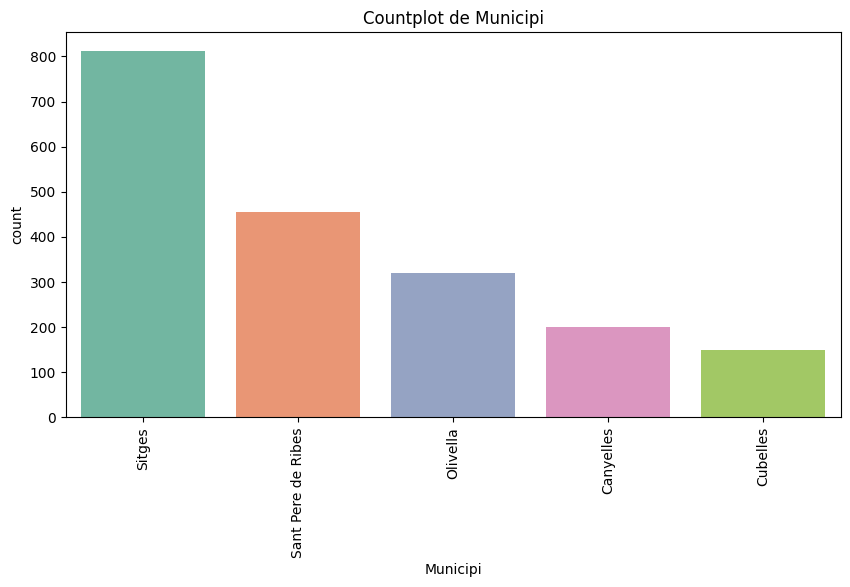

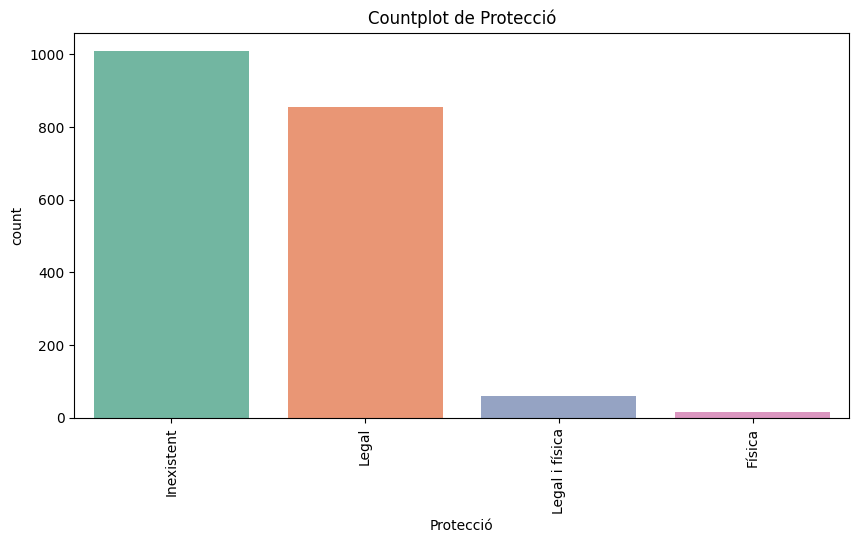

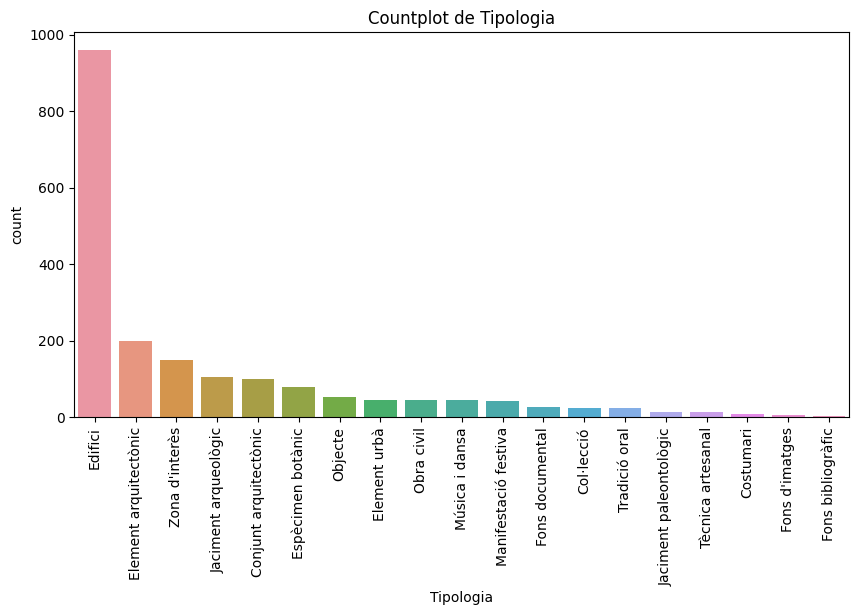

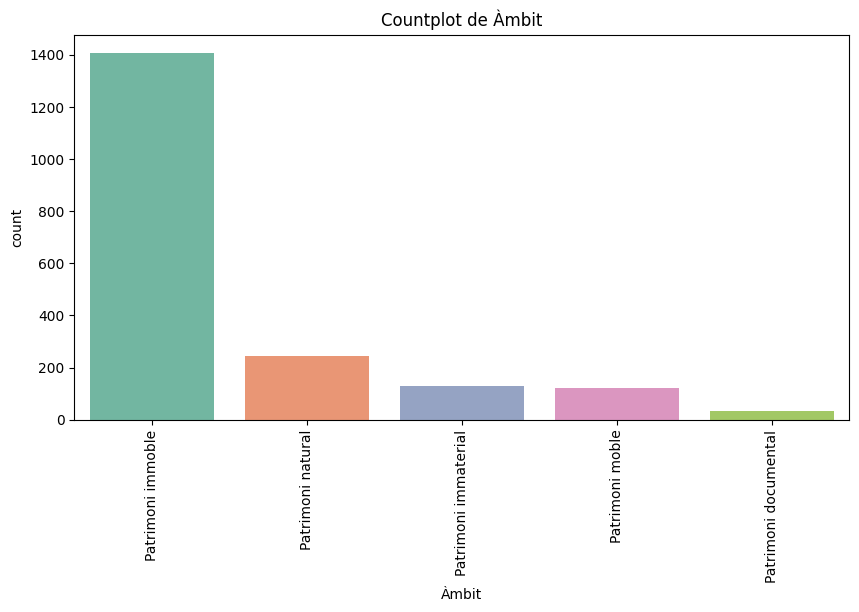

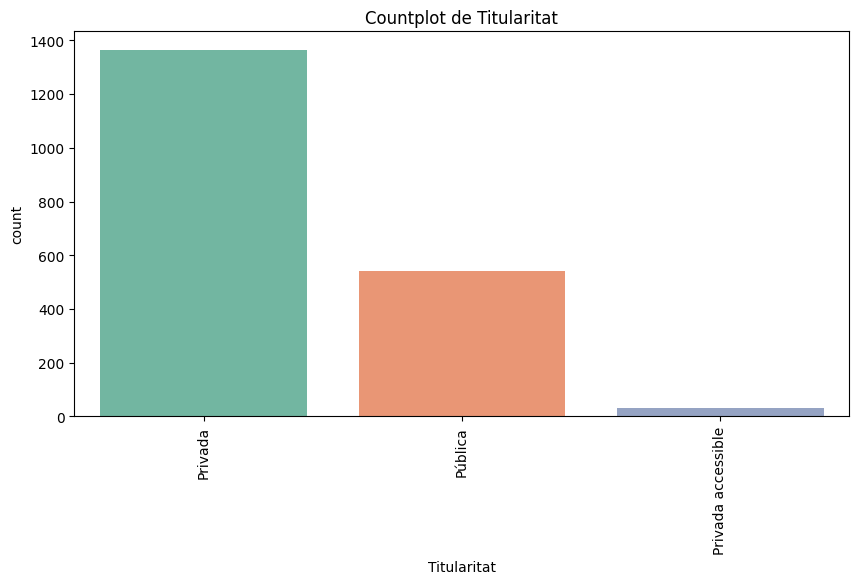

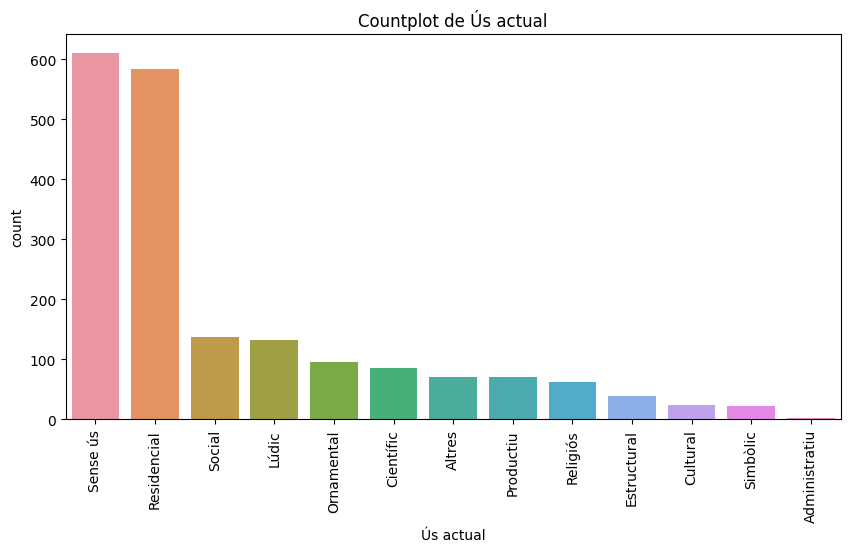

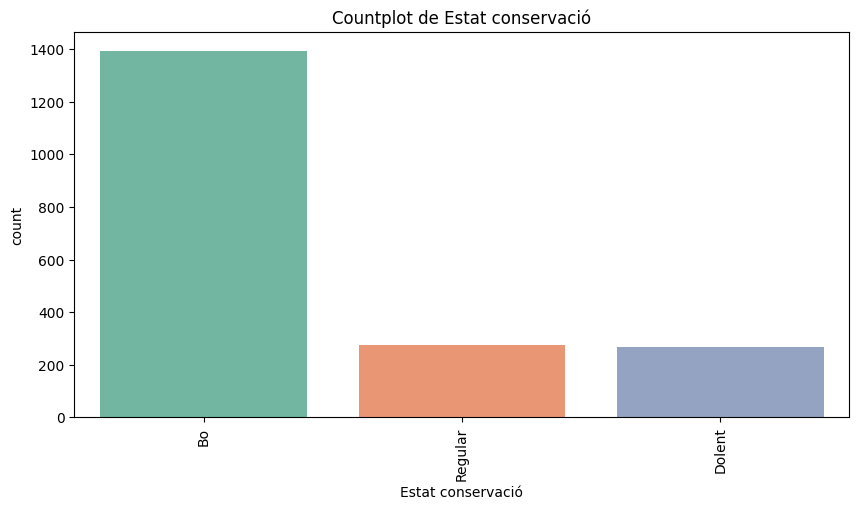

In [ ]:
plot_countplots(patrimoni)

Un cop fet l'anàlisi podem concloure que les dades estan força desaquilibrades. Amb la neteja hem reduit algunes variable a menys categories agrupant aquestes i hem esborrat d'altres. 

### **El preprocessat**

Procedirem a fer el preprocessat i tranformar la totalitat de varibales (menys el títol i el target) de categòriques a numèriques amb dues tècniques diferents: les categories que tinguin un ordre, els hi assignarem valors més a menys en format numèric i a les que no tinguin cap ordre, aplicarem la dummificació. 

Com que tenim tot de variables categòriques, convertirem la variable d' 'Estat conservació' en una lista amb valors específics. D'aquesta manera Bo =2, Regular =1, Dolent = 0. 

In [ ]:
orden = {'Bo': 2, 'Regular': 1, 'Dolent': 0}
patrimoni['Estat conservació'] = patrimoni['Estat conservació'].map(orden)

In [ ]:
patrimoni.head(10)

,Títol,Edat,Municipi,Protecció,Tipologia,Àmbit,Titularitat,Ús actual,Estat conservació
0,Forn de calç del Fondo de l'Obaga II,Moderna,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,0
1,Can Dori,Antiga,Canyelles,Inexistent,Jaciment arqueològic,Patrimoni immoble,Privada,Altres,0
2,Benedicció del terme,Contemporània,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,2
3,Carrerada de Carro,Sense data,Canyelles,Legal,Obra civil,Patrimoni immoble,Pública,Social,0
4,Fondo de l'Obaga,Sense data,Canyelles,Legal,Zona d'interès,Patrimoni natural,Privada,Social,2
5,Goigs en alabansa de Santa Maria de Magdalena,Contemporània,Canyelles,Inexistent,Música i dansa,Patrimoni immaterial,Pública,Residencial,2
6,Cementiri de Canyelles,Contemporània,Canyelles,Inexistent,Edifici,Patrimoni immoble,Pública,Altres,2
7,Bassa de Vora Sitges,Sense data,Canyelles,Inexistent,Zona d'interès,Patrimoni natural,Pública,Altres,2
8,Barraca de Can Pasqual II,Moderna,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,2
9,Barraca del bosc del Collet II,Moderna,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,2


In [ ]:
patrimoni['Edat'].fillna('Sense data', inplace=True)

En el cas de l'Edat, creiem que les categories tenen un ordre, llavors provarem d'assignar-hi valors també. 

In [ ]:
ordre = {'Contemporània': 6, 'Moderna': 5, 'Mitjana': 4, 'Antiga': 3, 'Sense data': 2, 'Prehistòria': 1}
patrimoni['Edat'] = patrimoni['Edat'].map(ordre)

Posar "Sense data" en segon lloc té sentit perquè la creació dels elements patrimonials sense data no és anterior a la prehistòria en cap cas. 

Comprovem ara quants elements té cada edat:

In [ ]:
patrimoni['Edat'].value_counts()

6    842
2    488
5    454
3     66
4     60
1     27
Name: Edat, dtype: int64

Mirem com queda de moment el preprocessat.

In [ ]:
patrimoni.head()

,Títol,Edat,Municipi,Protecció,Tipologia,Àmbit,Titularitat,Ús actual,Estat conservació
0,Forn de calç del Fondo de l'Obaga II,5,Canyelles,Inexistent,Edifici,Patrimoni immoble,Privada,Sense ús,0
1,Can Dori,3,Canyelles,Inexistent,Jaciment arqueològic,Patrimoni immoble,Privada,Altres,0
2,Benedicció del terme,6,Canyelles,Inexistent,Costumari,Patrimoni immaterial,Pública,Sense ús,2
3,Carrerada de Carro,2,Canyelles,Legal,Obra civil,Patrimoni immoble,Pública,Social,0
4,Fondo de l'Obaga,2,Canyelles,Legal,Zona d'interès,Patrimoni natural,Privada,Social,2


Ara dumifiquem les següents columnes que no tenen jerarquia:

In [ ]:
columns_to_dumify = ['Municipi', 'Protecció', 'Tipologia', 'Titularitat', 'Ús actual']
df_dummies = pd.get_dummies(patrimoni[columns_to_dumify], prefix=columns_to_dumify)
patrimoni = pd.concat([patrimoni, df_dummies], axis=1)
patrimoni = patrimoni.drop(columns_to_dumify, axis=1)

In [ ]:
patrimoni.head(10)

,Títol,Edat,Àmbit,Estat conservació,Municipi_Canyelles,Municipi_Cubelles,Municipi_Olivella,Municipi_Sant Pere de Ribes,Municipi_Sitges,Protecció_Física,...,Ús actual_Cultural,Ús actual_Estructural,Ús actual_Lúdic,Ús actual_Ornamental,Ús actual_Productiu,Ús actual_Religiós,Ús actual_Residencial,Ús actual_Sense ús,Ús actual_Simbòlic,Ús actual_Social
0,Forn de calç del Fondo de l'Obaga II,5,Patrimoni immoble,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Can Dori,3,Patrimoni immoble,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Benedicció del terme,6,Patrimoni immaterial,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Carrerada de Carro,2,Patrimoni immoble,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fondo de l'Obaga,2,Patrimoni natural,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Goigs en alabansa de Santa Maria de Magdalena,6,Patrimoni immaterial,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,Cementiri de Canyelles,6,Patrimoni immoble,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Bassa de Vora Sitges,2,Patrimoni natural,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Barraca de Can Pasqual II,5,Patrimoni immoble,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,Barraca del bosc del Collet II,5,Patrimoni immoble,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
patrimoni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937 entries, 0 to 1940
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Títol                             1937 non-null   object
 1   Edat                              1937 non-null   int64 
 2   Àmbit                             1937 non-null   object
 3   Estat conservació                 1937 non-null   int64 
 4   Municipi_Canyelles                1937 non-null   uint8 
 5   Municipi_Cubelles                 1937 non-null   uint8 
 6   Municipi_Olivella                 1937 non-null   uint8 
 7   Municipi_Sant Pere de Ribes       1937 non-null   uint8 
 8   Municipi_Sitges                   1937 non-null   uint8 
 9   Protecció_Física                  1937 non-null   uint8 
 10  Protecció_Inexistent              1937 non-null   uint8 
 11  Protecció_Legal                   1937 non-null   uint8 
 12  Protecció_Legal i fí

Ara passem a tenir 48 columnes, la majoria binàries.

Busquem la correlació entre totes les noves variables creades i després ho mostrem amb un heatmap.

In [ ]:
patrimoni.corr()

<ipython-input-63-0e0943f3dab4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  patrimoni.corr()


,Edat,Estat conservació,Municipi_Canyelles,Municipi_Cubelles,Municipi_Olivella,Municipi_Sant Pere de Ribes,Municipi_Sitges,Protecció_Física,Protecció_Inexistent,Protecció_Legal,...,Ús actual_Cultural,Ús actual_Estructural,Ús actual_Lúdic,Ús actual_Ornamental,Ús actual_Productiu,Ús actual_Religiós,Ús actual_Residencial,Ús actual_Sense ús,Ús actual_Simbòlic,Ús actual_Social
Edat,1.000000,0.183111,0.096675,0.041112,-0.397263,0.131338,0.103803,0.000487,-0.264158,0.236171,...,0.028737,-0.037857,-0.207144,0.031890,-0.038694,0.085937,0.433265,-0.237679,0.027259,-0.157957
Estat conservació,0.183111,1.000000,-0.043942,0.060277,-0.116207,-0.089841,0.159117,0.051296,-0.134586,0.095060,...,0.058573,-0.013496,0.148510,0.079878,-0.021670,0.094370,0.294220,-0.496842,0.041991,0.040252
Municipi_Canyelles,0.096675,-0.043942,1.000000,-0.098227,-0.151088,-0.188541,-0.289391,0.105126,0.272106,-0.271474,...,-0.038113,-0.036724,-0.051711,0.008098,-0.011464,0.013958,-0.146085,0.129683,0.091335,0.031588
Municipi_Cubelles,0.041112,0.060277,-0.098227,1.000000,-0.128179,-0.159952,-0.245511,-0.025502,0.009248,-0.022213,...,0.388006,0.082761,-0.008871,0.059053,-0.024754,0.056290,-0.054559,-0.091724,0.005626,0.026159
Municipi_Olivella,-0.397263,-0.116207,-0.151088,-0.128179,1.000000,-0.246030,-0.377631,-0.039226,0.381248,-0.366259,...,-0.049734,0.075088,-0.097981,0.020458,-0.018855,-0.034332,-0.237122,0.372554,-0.047592,-0.106210
Municipi_Sant Pere de Ribes,0.131338,-0.089841,-0.188541,-0.159952,-0.246030,1.000000,-0.471242,0.020512,0.024344,0.005877,...,-0.062063,0.041954,0.009633,0.024967,0.023210,0.056303,-0.069476,0.032696,0.021056,-0.062612
Municipi_Sitges,0.103803,0.159117,-0.289391,-0.245511,-0.377631,-0.471242,1.000000,-0.039332,-0.480576,0.449960,...,-0.095260,-0.114464,0.102107,-0.073712,0.014683,-0.061581,0.357620,-0.338688,-0.041797,0.099963
Protecció_Física,0.000487,0.051296,0.105126,-0.025502,-0.039226,0.020512,-0.039332,1.000000,-0.092117,-0.078448,...,-0.009895,-0.012663,0.046224,0.006963,-0.017106,-0.016198,-0.058040,-0.034620,-0.009469,-0.024372
Protecció_Inexistent,-0.264158,-0.134586,0.272106,0.009248,0.381248,0.024344,-0.480576,-0.092117,1.000000,-0.925947,...,0.032681,0.041824,0.214234,0.128527,-0.041327,0.036019,-0.531930,0.373005,0.063781,-0.086120
Protecció_Legal,0.236171,0.095060,-0.271474,-0.022213,-0.366259,0.005877,0.449960,-0.078448,-0.925947,1.000000,...,-0.071264,-0.031053,-0.211255,-0.116542,0.050911,-0.022134,0.499668,-0.329792,-0.055928,0.099769


<ipython-input-64-1b3e60256c48>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(patrimoni.corr(), annot=True)


<Axes: >

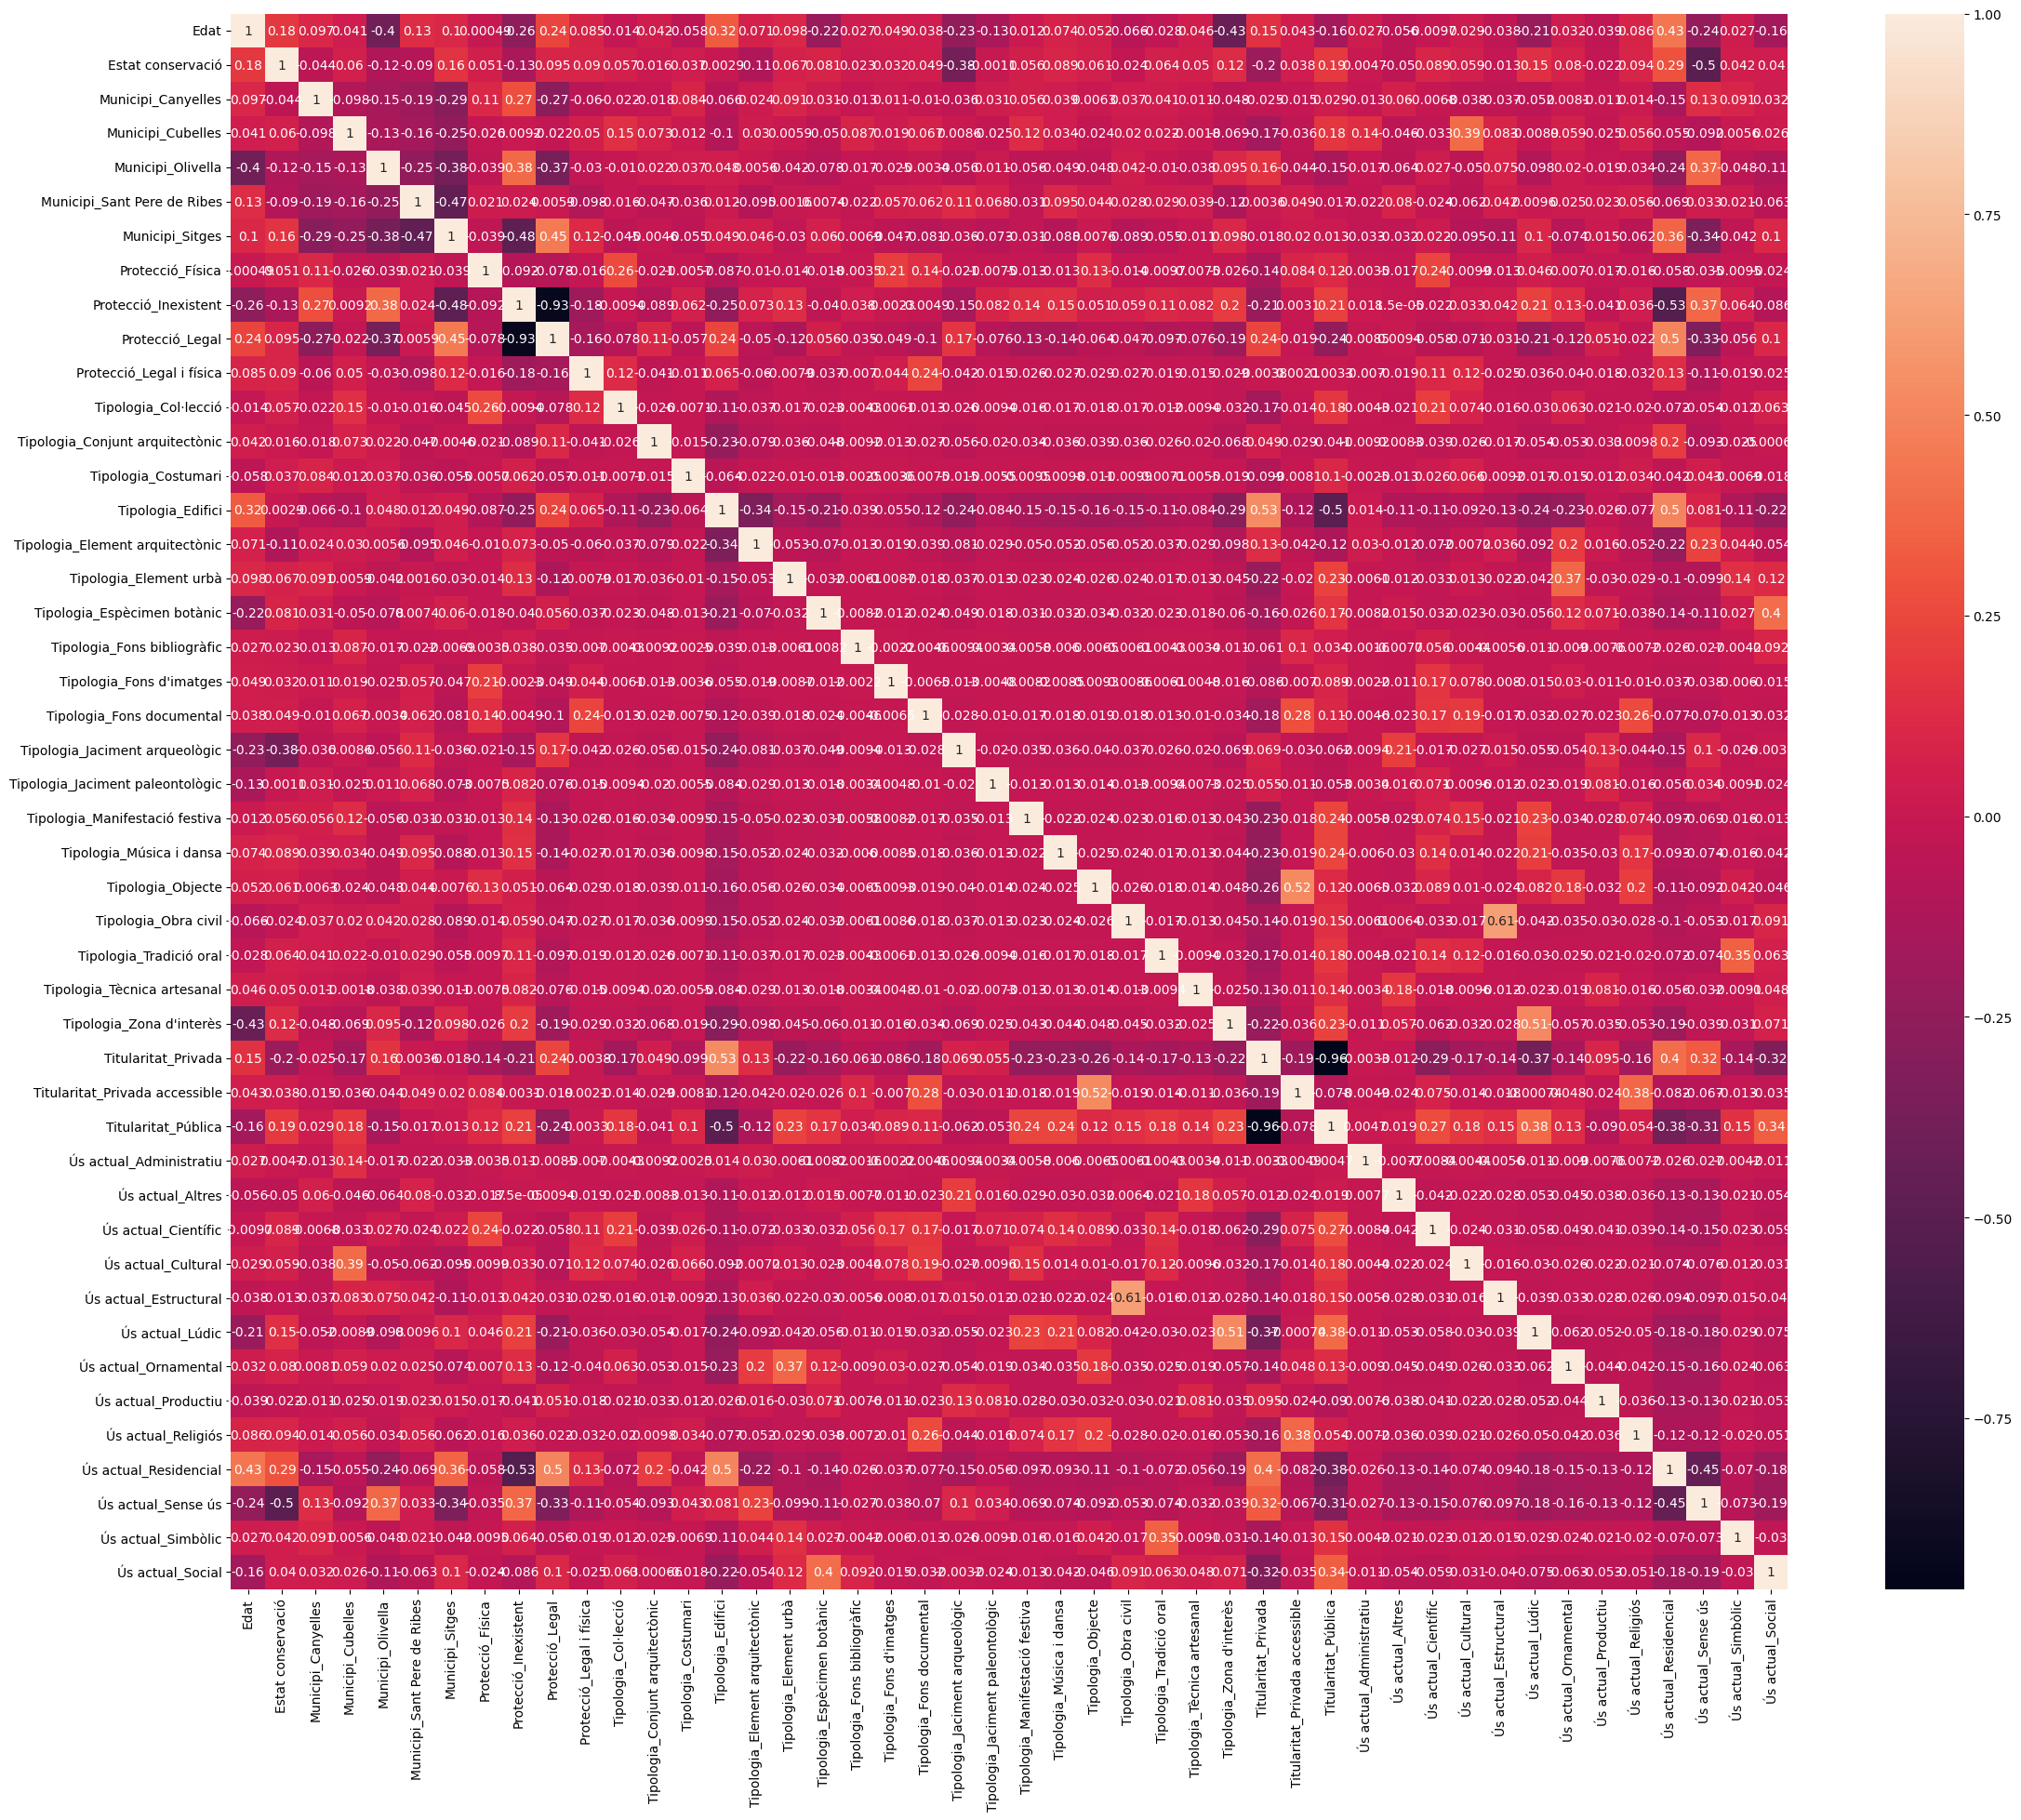

In [ ]:
plt.figure(figsize=(27, 22))
sns.heatmap(patrimoni.corr(), annot=True)

Com es pot apreciar, hi ha certs patrons de correlació. Per mencionar alguns:
- La tipologia d'obra civil té força relació amb l'ús estructural. 
- Hi ha força elements de tipologia objecte que són de titularitat privada acessible. 
- Sovint els elements d'ús residencial tenen protecció legal. 
- Sovint els edificis tenen titularitat privada i ús residencial, fet lògic. 
- Freqüentment aquells elements patrimonials que estan a Sitges tenen protecció legal.
- Les zones d'interés sovint tenen un ús actual lúdic i són de tituaritat pública.
- Les elements de titularitat pública sovint tenen un ús social.
- Les tradicions orals sovint tenen ús simbòlic.
- Els elements urbans sovint tenen ús ornamental (escultures, monuments, etc).
- L'edat té correlació amb l'estat de conservació, així que en general els elements més antics estan pitjor conservats.
- Olivella, Sant Pere de Ribes i Sitges també mostren de vegades pitjors estats de conservació.

Tot i que les correlacions no són molt altes - ja que són variables categòriques transformades i la correlació no té la rellevanància que tindria amb variables numèriques-, es pot dir que això és molt significatiu alhora de trobar patrons i classificar correctament els elements amb els models. 

Per la matririu de confussió que veurem més tard, obtenim el número corresponent a cada categoria del target.

In [ ]:
categorias = patrimoni['Àmbit'].unique()
mapa_clases = {i: categoria for i, categoria in enumerate(categorias)}
print(mapa_clases)

{0: 'Patrimoni immoble', 1: 'Patrimoni immaterial', 2: 'Patrimoni natural', 3: 'Patrimoni moble', 4: 'Patrimoni documental'}


### **Selecció i aplicació dels models**

Seleccionem quatre models que solen ser adequats per les classificacions supervisades multiclasse. N'hi ha també d'altres, i alguns de més adequats per les classificacions binàries. En aquest cas són el model SVC, el Logistic Regression(multinomial), el Random Forest i el Gradient Boosting Classifier. Els aplicarem fent un pipeline i aplicarem amb pipeline, també, l'undersampling i l'oversampling per tal de balencejar les dades. Això serà útil, ja que sense aplicar-ho, la puntuació del Cross Validation és alta però les categories més petites del target no es prediuen correctament. 

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
from copy import deepcopy

# Desactivem les advertencies
warnings.filterwarnings("ignore")

# Classifiquem les dades en X i y
X = patrimoni.drop(['Àmbit', 'Títol'], axis=1)
y = patrimoni['Àmbit']

# Definim les estratègies de resampling 
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Definim els models
svc_model = SVC()
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()

# Construim el pipeline
pipeline = Pipeline([
    ('under', undersampler),
    ('over', oversampler),
    ('model', None)  
])

# Definim el paràmetre grid pel grid search
param_grid = {
    'model': [svc_model, logreg_model, rf_model, gb_model]
}

# Dividim les dades en el training set i el test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fem el Gridsearch amb el Cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Agafem el millor model trobat pel grid search
best_model = grid_search.best_estimator_

# Definim els models i els seus noms
models = {'SVC': svc_model, 'Logistic Regression': logreg_model, 'Random Forest': rf_model, 'Gradient Boosting': gb_model}

# Calcula i imprimeix les mètriques del model amb validació creuada
for model_name, model in models.items():
    # Calcula i imprimeix les mètriques del model amb validació creuada
    pipeline.steps[-1] = ('model', model)
    pipelineCV = deepcopy(pipeline)
    # Ajusteu el model a tot el conjunt d'entrenament
    pipeline.fit(X_train, y_train)

    # Predicció sobre el conjunt de test
    y_pred = pipeline.predict(X_test)

    # Calcular les mètriques dels models
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion = confusion_matrix(y_test, y_pred)

    # Fer el cross-validation dels models
    cv_scores = cross_val_score(pipelineCV, X, y, cv=10, scoring='accuracy')

    # Imprimim les mètriques dels models amb les notes del cross_validation
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", confusion)
    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean(), "\n")

Model: SVC
Accuracy: 0.8556701030927835
Precision: 0.6839809523809524
Recall: 0.7246394833236938
F1 Score: 0.6950315172867543
Confusion Matrix:
 [[  3   3   0   1   0]
 [  0  19   1   0  10]
 [  3  16 247   1  13]
 [  1   1   0  14   3]
 [  0   1   2   0  49]]
Cross-Validation Scores: [0.86597938 0.68556701 0.56185567 0.78865979 0.89690722 0.91237113
 0.91752577 0.93782383 0.9015544  0.83419689]
Mean CV Accuracy: 0.8302441108915122 

Model: Logistic Regression
Accuracy: 0.9484536082474226
Precision: 0.8645102389236623
Recall: 0.8978484673221516
F1 Score: 0.8779664668783267
Confusion Matrix:
 [[  5   1   0   1   0]
 [  0  30   0   0   0]
 [  0   8 268   0   4]
 [  1   0   0  17   1]
 [  1   0   3   0  48]]
Cross-Validation Scores: [0.92268041 0.86082474 0.92783505 0.92783505 0.97938144 0.96391753
 1.         0.99481865 0.98963731 0.93782383]
Mean CV Accuracy: 0.9504754019550237 

Model: Random Forest
Accuracy: 0.9329896907216495
Precision: 0.8098965848965849
Recall: 0.8938741083477926
F

### **Avaluació dels models**

Els resultats obtinguts mostren les mètriques de desenvolupament de cada model a la classificació de les dades. 

- El **model SVC** té una precisió de 0.68, cosa que indica que encerta en un percentatge relativament alt de classificacions. No obstant això, el recall i el F1 Score no són gaire alts, cosa que indica que hi pot haver dificultats per identificar correctament algunes classes. La matriu de confusió mostra com es distribueixen les classificacions errònies a diferents classes. La matriu de confusió mostra que aquest model té algunes dificultats a la classificació de les classes. Per exemple, es confonen algunes mostres de la classe 0 (patrimoni immoble) amb la classe 1 (patrimoni immaterial) i viceversa. També hi ha confusions entre les classes 1 (patrimoni immaterial)  i 4 (patrimoni documental). La classe 2 (patrimoni natural) és la millor classificada, amb la majoria de les mostres correctament etiquetades.


- El model de **Regressió Logística** mostra una precisió més alta, assolint 0.86, cosa que indica un millor rendiment general en comparació del model SVC. El recall i l'F1 Score també són força alts, cosa que suggereix una bona capacitat per identificar correctament les classes.El model de regressió logística té un millor exercici en comparació del model SVC. La matriu de confusió mostra que les classes 0, 1 i 4 (patrimoni immoble, patrimoni immaterial i patrimoni documental) han estat ser classificades de manera força precisa, amb molt pocs errors. No obstant això, hi ha algunes confusions a la classificació de la classe 2 (patrimoni natural).

- El model **Random Forest** té resultats similars al model de Regressió Logística, amb una precisió de 0.78 i un rendiment sòlid en termes de recall i F1 Score. També mostra un bon rendiment en general a la matriu de confussió. La majoria de les classes són classificades correctament, encara que hi ha algunes confusions entre les classes 1 i 2 (patrimoni immaterial i patrimoni natural). La classe 4 (patrimoni documental) és la millor classificada, amb totes les mostres correctament etiquetades.

- El model **Gradient Boosting** mostra una precisió de 0.91, cosa que indica un rendiment molt bo. A més, té un recall molt alt de 0.97, fet que suggereix una gran capacitat per recuperar correctament les classes positives. El F1 Score també és alt, cosa que indica un equilibri entre precisió i recall. La matriu de confusió mostra que les classes van ser classificades correctament sense gairebé errades. Això indica una alta precisió i un bon rendiment general del model.

En general, els models de Regressió Logística, Random Forest i Gradient Boosting mostren un rendiment sòlid en comparació del model SVC. Aquests models aconsegueixen una alta precisió i un equilibri entre recall i F1 Score. El que millors puntuacions obté en tots els sentits és el Gradient Boosting. 


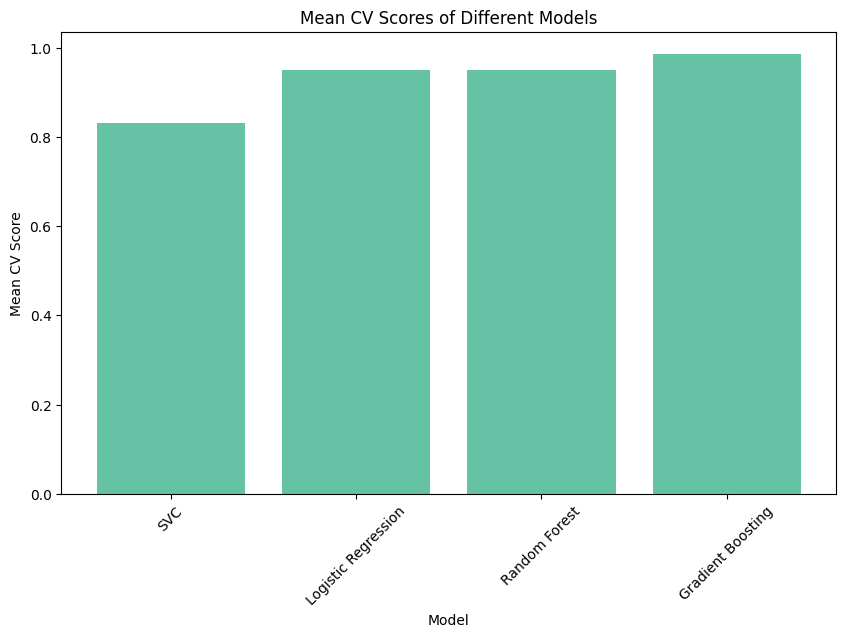

In [ ]:
import matplotlib.pyplot as plt

models = {'SVC': svc_model, 'Logistic Regression': logreg_model, 'Random Forest': rf_model, 'Gradient Boosting': gb_model}
model_names = []
mean_cv_scores = []
for model_name, model in models.items():
    pipeline.steps[-1] = ('model', model)
    cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')
    mean_cv_score = cv_scores.mean()
    model_names.append(model_name)
    mean_cv_scores.append(mean_cv_score)
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_cv_scores)
plt.xlabel('Model')
plt.ylabel('Mean CV Score')
plt.title('Mean CV Scores of Different Models')
plt.xticks(rotation=45)
plt.show()

Les puntuacions en aquest cas són: 
- SVC: 0.83
- Logistic Regression: 0.95
- Random Forest: 0.95
- Gradient Boosting: 0.98

Comparant les puntuacions de la mitjana de les cross validations, també destaca per sobre de tots el Gradient Boosting. 

Per últim, visualitzarem la classificació d'unes quantes mostres comparant l'etiqueta orginal amb la predita. Podem comprovar que la predicció és molt bona, tot i que, algunes vegades li costa identificar el patrimoni immaterial i el confon amb el l'immoble, per exemple. Dit això, concloure que s'han aconseguit uns molt bons resultats de classificació amb quasi tots els models, menys el SVC, els resultats del qual són una mica pitjors. El millor model ha resultat ser el Gradient Boosting.

In [ ]:
data = []
for i, index in enumerate(X_test.index):
    text = X_test.iloc[i]
    title = patrimoni.loc[index, 'Títol']
    true_label = y_test.iloc[i]
    predicted_label = y_pred[i]
    
    data.append({
        'Título': title,
        'Texto': text,
        'Ámbito verdadero': true_label,
        'Ámbito predicho': predicted_label
    })

true_pred = pd.DataFrame(data)

true_pred

,Título,Texto,Ámbito verdadero,Ámbito predicho
0,Barraca 23,Edat 2 Estat co...,Patrimoni immoble,Patrimoni immoble
1,La Granja del Carme,Edat 6 Estat co...,Patrimoni immoble,Patrimoni immoble
2,Masia de la Carretera,Edat 5 Estat co...,Patrimoni immoble,Patrimoni immoble
3,Emissari de Sitges,Edat 2 Estat co...,Patrimoni immoble,Patrimoni immaterial
4,Casa Josep Carbonell i Mussons,Edat 6 Estat co...,Patrimoni immoble,Patrimoni immoble
5,"C/ Parellades, 12",Edat 6 Estat co...,Patrimoni immoble,Patrimoni immoble
6,Casa Joaquim de Miró,Edat 6 Estat co...,Patrimoni immoble,Patrimoni immoble
7,Garrofer de Can Bruguera,Edat 2 Estat co...,Patrimoni natural,Patrimoni natural
8,"C/ Major, 8-10 - C/ Sant Domènec, 2",Edat 5 Estat co...,Patrimoni immoble,Patrimoni immoble
9,Forn de les Timbes,Edat 3 Estat co...,Patrimoni immoble,Patrimoni immoble
